In [1]:
#| default_exp experiments

In [2]:
#| hide
# %reload_ext autoreload
# %autoreload 0


# install (Colab)

In [3]:
# try: 
#     import fastcore as FC
# except ImportError: 
#     !pip install -q fastcore
# try:
#     import rich
# except ImportError:
#     !pip install -q rich


Note: we're using the `testbed` branch of PanelCleaner.


In [4]:
# !pip install -q git+https://github.com/civvic/PanelCleaner.git@testbed

# Testing `Tesseract` OCR for Comics
> Accuracy Enhancements for OCR in `PanelCleaner`


# Prologue

In [5]:
#| export
from __future__ import annotations

import dataclasses
import difflib
import functools
import json
import shutil
from collections import defaultdict
from enum import Enum
from pathlib import Path
from typing import Any
from typing import Callable
from typing import cast
from typing import Mapping
from typing import Self
from typing import TypeAlias

import fastcore.all as FC
import ipywidgets as W
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pcleaner.config as cfg
import pcleaner.ctd_interface as ctm
import pcleaner.image_ops as ops
import pcleaner.ocr.ocr as ocr
import pcleaner.structures as st
import torch
from IPython.display import clear_output
from IPython.display import display
from IPython.display import HTML
from ipywidgets.widgets.interaction import show_inline_matplotlib_plots
from loguru import logger
from pcleaner.ocr.ocr_tesseract import TesseractOcr
from PIL import Image
from PIL import ImageFilter
from rich.console import Console
from tqdm.notebook import tqdm


In [6]:
#| export

from helpers import *
from ocr_metric import *


In [7]:
import copy

import fastcore.xtras  # patch Path with some utils
import pcleaner.cli_utils as cli
import pcleaner.preprocessor as pp
import rich
from fastcore.test import *  # type: ignore


# Helpers

In [8]:
# pretty print by default
# %load_ext rich

In [9]:
#| exporti
console = Console(width=104, tab_size=4, force_jupyter=True)
cprint = console.print


## Tesseract installation

In [10]:
out = !tesseract --version
out


['tesseract 5.3.4',
 ' leptonica-1.84.1',
 '  libgif 5.2.1 : libjpeg 8d (libjpeg-turbo 3.0.0) : libpng 1.6.43 : libtiff 4.6.0 : zlib 1.2.11 : libwebp 1.4.0 : libopenjp2 2.5.2',
 ' Found NEON',
 ' Found libarchive 3.7.2 zlib/1.2.11 liblzma/5.4.6 bz2lib/1.0.8 liblz4/1.9.4 libzstd/1.5.6',
 ' Found libcurl/8.4.0 SecureTransport (LibreSSL/3.3.6) zlib/1.2.11 nghttp2/1.51.0']

###  Install jpn_vert tesserac lang
> It has much better results than the default `jpn` language model.




Download from [tessdata_best](https://github.com/tesseract-ocr/tessdata_best), or from [here](https://groups.google.com/g/tesseract-ocr/c/FwjSZzoVgeg/m/u-zyFYQiBgAJ) trained for vertical Japanese text as found in manga.

Note: I've not play much with this one, `managa-ocr` is surely a much better fit, but it can be educational to compare.

I have copied models in my GDrive, and installed (in my Ubuntu, similar in Mac):
```bash
cd model
ln -s jpn_vert_tessdata_best.traineddata /usr/share/tesseract-ocr/5/tessdata/jpn_vert.traineddata
```

In [11]:
out = !tesseract --list-langs
tessdata = Path(out[0].split('"')[1])
tessdata, [', '.join(sub) for sub in [out[i:i + 15] for i in range(1, len(out), 15)]]


(Path('/opt/homebrew/share/tessdata'),
 ['afr, amh, ara, asm, aze, aze_cyrl, bel, ben, bod, bos, bre, bul, cat, ceb, ces',
  'chi_sim, chi_sim_vert, chi_tra, chi_tra_vert, chr, cos, cym, dan, deu, div, dzo, ell, eng, enm, epo',
  'equ, est, eus, fao, fas, fil, fin, fra, frk, frm, fry, gla, gle, glg, grc',
  'guj, hat, heb, hin, hrv, hun, hye, iku, ind, isl, ita, ita_old, jav, jpn, jpn_vert',
  'kan, kat, kat_old, kaz, khm, kir, kmr, kor, kor_vert, lao, lat, lav, lit, ltz, mal',
  'mar, mkd, mlt, mon, mri, msa, mya, nep, nld, nor, oci, ori, osd, pan, pol',
  'por, pus, que, ron, rus, san, script/Arabic, script/Armenian, script/Bengali, script/Canadian_Aboriginal, script/Cherokee, script/Cyrillic, script/Devanagari, script/Ethiopic, script/Fraktur',
  'script/Georgian, script/Greek, script/Gujarati, script/Gurmukhi, script/HanS, script/HanS_vert, script/HanT, script/HanT_vert, script/Hangul, script/Hangul_vert, script/Hebrew, script/Japanese, script/Japanese_vert, script/Kannada, script/

In [12]:
langs = tessdata.ls()
cprint([p.resolve() for p in langs if 'eng' in p.name] + [p.resolve() for p in langs if 'jpn' in p.name])



[
    Path('/Users/vic/dev/repo/DL-mac/PanelCleaner/_testbed/model/eng_tessdata_best_410.traineddata'),
    Path('/Users/vic/dev/repo/DL-mac/PanelCleaner/_testbed/model/jpn_vert_tessdata_best.traineddata'),
    Path('/Users/vic/dev/repo/DL-mac/PanelCleaner/_testbed/model/jpn_tessdata_best.traineddata')
]

## OCR results clean-up

In [13]:
#| export

def remove_multiple_whitespaces(text):
    return ' '.join(text.split())

    
def postprocess_ocr(text):
    "Basic postprocessing for English Tesseract OCR results."
    return ' '.join(remove_multiple_whitespaces(text).splitlines()).capitalize()

def accuracy_ocr_naive(text, ground_truth):
    return sum(1 for a, b in zip(text, ground_truth) if a == b) / len(text)


def accuracy_ocr_difflib(text, ground_truth):
    """
    Calculates the OCR accuracy based on the similarity between the OCR text and the ground truth text,
    using difflib's SequenceMatcher to account for differences in a manner similar to git diffs.

    :param text: The OCR-generated text.
    :param ground_truth: The ground truth text.
    :return: A float representing the similarity ratio between the OCR text and the ground truth, 
            where 1.0 is identical.
    """
    # Initialize the SequenceMatcher with the OCR text and the ground truth
    matcher = difflib.SequenceMatcher(None, text, ground_truth)
    
    # Get the similarity ratio
    similarity_ratio = matcher.ratio()
    
    return similarity_ratio

## Ground truth

In [14]:
#| export

def ground_truth_path(page_data: st.PageData):
    path = Path(page_data.original_path)
    return path.with_stem(path.stem + '_gt').with_suffix('.txt')


def read_ground_truth(page_data: st.PageData):
    gts_path = ground_truth_path(page_data)
    if gts_path.exists():
        gts = gts_path.read_text(encoding="utf-8").splitlines()
    else:
        gts = ["" for _ in range(len(page_data.boxes))]
    return gts


## Cropping

In [15]:
#| export

def dilate_by_fractional_pixel(image, dilation_fraction, filter_base_size=3):
    """
    Dilates an image by a specified fractional pixel amount. The function calculates 
    the necessary scaling factor and filter size based on the desired dilation fraction.

    :param image: A PIL Image object (1-bit mode).
    :param dilation_fraction: The desired fractional pixel amount for dilation (e.g., 0.2).
    :param filter_base_size: The base size of the dilation filter to apply on the scaled image.
                             This size is adjusted based on the scaling factor to achieve the
                             desired dilation effect.
    :return: A PIL Image object after dilation, converted back to grayscale.
    """
    # Calculate the scale factor based on the desired dilation fraction
    scale_factor = int(1 / dilation_fraction)
    
    # Adjust the filter size based on the scale factor
    # This ensures the dilation effect is proportional to the desired fraction
    filter_size = max(1, filter_base_size * scale_factor // 5)

    # Convert the image to grayscale for more nuanced intermediate values
    image_gray = image.convert("L")

    # Resize the image to a larger size using bicubic interpolation
    larger_size = (int(image.width * scale_factor), int(image.height * scale_factor))
    image_resized = image_gray.resize(larger_size, Image.BICUBIC)

    # Apply the dilation filter to the resized image
    dilated_image = image_resized.filter(ImageFilter.MaxFilter(filter_size))

    # Resize the image back to its original size using bicubic interpolation
    image_dilated_fractional_pixel = dilated_image.resize(image.size, Image.BICUBIC)

    return image_dilated_fractional_pixel


In [16]:
#| export

def extract_text(image, text_mask, box):
    cropped_image = crop_box(box, image)
    cropped_mask = crop_box(box, text_mask)
    extracted = ops.extract_text(cropped_image, cropped_mask)
    return cropped_image, cropped_mask, extracted


## Lang
> language name to a language code  
> every one has language codes: tesseract, comic-text-detector, earthlings...


In [17]:
#| exporti
_lang2pcleaner = {'English': st.DetectedLang.ENG, 'Japanese': st.DetectedLang.JA, 'Spanish': st.DetectedLang.ENG,
                    'French':st.DetectedLang.ENG}
# _lang2tesseract = {'English': 'eng', 'Japanese': 'jpn'}
_lang2tesseract = {'English': 'eng', 'Japanese': 'jpn_vert', 'Spanish': 'spa', 'French': 'fra'}


In [18]:
#| export
def lang2pcleaner(lang: str):
    return _lang2pcleaner[lang]

def lang2tesseract(lang: str):
    return _lang2tesseract[lang]


----
# Tesseract experiments

# PanelCleaner Configuration
> Adapt `PanelCleaner` `Config` current config to this notebook.


In [19]:
config = cfg.load_config()
config.cache_dir = Path(".")

cache_dir = config.get_cleaner_cache_dir()

profile = config.current_profile
preprocessor_conf = profile.preprocessor
# Modify the profile to OCR all boxes.
# Make sure OCR is enabled.
preprocessor_conf.ocr_enabled = True
# Make sure the max size is infinite, so no boxes are skipped in the OCR process.
preprocessor_conf.ocr_max_size = 10**10
# Make sure the sus box min size is infinite, so all boxes with "unknown" language are skipped.
preprocessor_conf.suspicious_box_min_size = 10**10
# Set the OCR blacklist pattern to match everything, so all text gets reported in the analytics.
preprocessor_conf.ocr_blacklist_pattern = ".*"

gpu = torch.cuda.is_available() or torch.backends.mps.is_available()
model_path = config.get_model_path(gpu)
device = ("mps" if torch.backends.mps.is_available() else "cuda") if model_path.suffix == ".pt" else "cpu"


# Test images
> `IMAGE_PATHS` is a list of image file paths that are used as input for testing the OCR methods.

In [20]:
media_path = Path("media/")

IMAGE_PATHS = sorted(
    [_ for _ in media_path.glob("*") if _.is_file() and _.suffix.lower() in [".jpg", ".png", ".jpeg"]])

[f"{i:02}: {_.name}" for i,_ in enumerate(IMAGE_PATHS)]


['00: Action_Comics_1960-01-00_(262).JPG',
 '01: Adolf_Cap_01_008.jpg',
 '02: Barnaby_v1-028.png',
 '03: Barnaby_v1-029.png',
 '04: Buck_Danny_-_12_-_Avions_Sans_Pilotes_-_013.jpg',
 '05: Cannon-292.jpg',
 '06: Contrato_con_Dios_028.jpg',
 '07: Erase_una_vez_en_Francia_02_88.jpg',
 '08: FOX_CHILLINTALES_T17_012.jpg',
 '09: Furari_-_Jiro_Taniguchi_selma_056.jpg',
 '10: Galactus_12.jpg',
 '11: INOUE_KYOUMEN_002.png',
 '12: MCCALL_ROBINHOOD_T31_010.jpg',
 '13: MCCAY_LITTLENEMO_090.jpg',
 '14: Mary_Perkins_On_Stage_v2006_1_-_P00068.jpg',
 '15: PIKE_BOYLOVEGIRLS_T41_012.jpg',
 '16: Sal_Buscema_Spaceknights_&_Superheroes_Ocular_Edition_1_1.png',
 '17: Sal_Buscema_Spaceknights_&_Superheroes_Ocular_Edition_1_1_K.png',
 '18: Sal_Buscema_Spaceknights_&_Superheroes_Ocular_Edition_1_2.png',
 '19: Spirou_Et_Fantasio_Integrale_06_1958_1959_0025_0024.jpg',
 '20: Strange_Tales_172005.jpg',
 '21: Strange_Tales_172021.jpg',
 '22: Tarzan_014-21.JPG',
 '23: Tintin_21_Les_Bijoux_de_la_Castafiore_page_39.jp

# Results helper
> Dataclass helper to store and display results


In [21]:
#| export

@dataclasses.dataclass
class ResultOCR:
    block_idx: int
    image: Image.Image | None
    ocr: str
    page_data: st.PageData
    gts: list[str]
    description: str = dataclasses.field(default='', kw_only=True)

    def __post_init__(self): 
        if self.image is None:
            cache_path = self.cache_path()
            if cache_path.exists():
                self.image = Image.open(cache_path)

    @property
    def acc(self):
        self._acc = accuracy_ocr_difflib(self.ocr, self.gts[self.block_idx])
        return self._acc
    @property
    def suffix(self): return f"{self.block_idx}_{self.description}"

    def diff_tagged(self):
        _, html2 = get_text_diffs_html(self.gts[self.block_idx], self.ocr, False)
        return f"<span style='font-size: 14px;'>{html2}</span>"
    
    def cache_path(self, suffix: str | None = None):
        suffix = self.suffix + (('_'+suffix) if suffix else '')
        parent = Path(self.page_data.image_path).parent
        img_name = Path(self.page_data.original_path).stem
        box_image_path = parent / f"{img_name}_{suffix}.png"
        return box_image_path
    
    def cache_image(self, image: Image.Image | None = None, suffix: str | None = None):
        image = image or (self.image if not suffix else None)
        box_image_path = self.cache_path(suffix)
        if image and not box_image_path.exists():
            image.save(box_image_path)
        return box_image_path


    def as_html(self):
        acc_html = f"<br/><strong><span style='color: red;'>{self.acc:.2f}</span></strong>"
        box_image_path = self.cache_image()
        html1 = get_columns_html([[box_image_path], [self.ocr + acc_html]])
        html_str1, html_str2 = get_text_diffs_html(self.gts[self.block_idx], self.ocr)
        html2 = f"<pre style='font-size: 14px;'>{html_str1}<br/>{html_str2}</pre>"
        return html1 + '\n<br/>\n' + html2

    def __repr__(self): 
        return f"{type(self).__name__}#block {self.block_idx:02}: {self.acc:.2f}||{self.ocr}"
    
    def display(self): display(HTML(self.as_html()))
    
    def _ipython_display_(self): self.display()

    def to_dict(self):
        d = dataclasses.asdict(self)
        d['image'] = d['page_data'] = d['gts'] = None
        return d

    # @classmethod
    # def from_dict(cls, d: dict, page_data: st.PageData, gts: list[str]):
    #     return cls(**(d | {'page_data':page_data, 'gts':gts}))


@dataclasses.dataclass
class ResultOCRExtracted(ResultOCR):

    def __repr__(self): return super().__repr__()
    def as_html(self):
        html_str1, html_str2 = get_text_diffs_html(self.gts[self.block_idx], self.ocr)
        diff_html = f"<pre style='font-size: 14px;'>{html_str1}<br/>{html_str2}</pre>"
        cropped_image_path = self.cache_image(None, "cropped")
        cropped_mask_path = self.cache_image(None, "mask")
        result_path = self.cache_image()
        return '\n<br/>\n'.join([
            get_image_grid_html([cropped_image_path, cropped_mask_path, result_path], 1, 3), 
            acc_as_html(self.acc), 
            diff_html
        ])


# CropMethod
> Box cropping methods.


In [22]:
#| export

class CropMethod(Enum):
    INITIAL_BOX = 'Initial box'
    DEFAULT = 'Default'
    DEFAULT_GREY_PAD = 'Default, grey pad'
    PADDED_4 = 'Padded 4px'
    PADDED_8 = 'Padded 8px'
    EXTRACTED_INIT_BOX = 'Extracted, init box'
    PADDED_4_EXTRACTED = 'Padded 4, extracted'
    PADDED_8_EXTRACTED = 'Padded 8, extracted'
    PADDED_8_DILATION_1 = 'Padded 8, dilation 1'
    PAD_8_FRACT_0_5 = 'Pad 8, fract. 0.5'
    PAD_8_FRACT_0_2 = 'Pad 8, fract. 0.2'

    @classmethod
    def __display_names__(cls):
        return dict(
            zip([_.value for _ in cls], 
            cls))


CM = CropMethod

_IMAGE_METHODS = [CM.INITIAL_BOX, CM.DEFAULT, CM.DEFAULT_GREY_PAD, 
                    CM.PADDED_4, CM.PADDED_8]
_EXTRACTED_METHODS = [CM.EXTRACTED_INIT_BOX, CM.PADDED_4_EXTRACTED, 
                        CM.PADDED_8_EXTRACTED, CM.PADDED_8_DILATION_1, 
                        CM.PAD_8_FRACT_0_5, CM.PAD_8_FRACT_0_2]


def crop_by_image(method: CM, 
        box: st.Box, 
        base: Image.Image, 
        preproc: cfg.PreprocessorConfig,
    ):
    image = None
    match method:
        case CM.INITIAL_BOX :
            image = crop_box(box, base)
        case CM.DEFAULT:
            padded2_4 = (
                box.pad(preproc.box_padding_initial, base.size).right_pad(
                            preproc.box_right_padding_initial, base.size))
            image = crop_box(padded2_4, base)
        case CM.DEFAULT_GREY_PAD:
            image = crop_box(box, base)
            image = ops.pad_image(image, 8, fill_color=(128, 128, 128))
        case CM.PADDED_4:
            padded4 = box.pad(4, base.size)
            image = crop_box(padded4, base)
        case CM.PADDED_8:
            padded4 = box.pad(8, base.size)
            image = crop_box(padded4, base)
        case _: pass
    return image


def crop_by_extracted(method: CM, 
        box: st.Box, 
        base: Image.Image, 
        mask: Image.Image,
        cropped_image_path: Path,
        cropped_mask_path: Path,
        dilated: dict[float, Image.Image]
    ):
    cropped_image, cropped_mask, image = None, None, None
    if method in _EXTRACTED_METHODS:
        if not cropped_image_path.exists() or not cropped_mask_path.exists():
            match method:
                case CM.EXTRACTED_INIT_BOX:
                    cropped_image, cropped_mask, image = extract_text(base, mask, box)
                case CM.PADDED_4_EXTRACTED:
                    padded4 = box.pad(4, base.size)
                    cropped_image, cropped_mask, image = extract_text(base, mask, padded4)
                case CM.PADDED_8_EXTRACTED:
                    padded8 = box.pad(8, base.size)
                    cropped_image, cropped_mask, image = extract_text(base, mask, padded8)
                case CM.PADDED_8_DILATION_1:
                    padded8 = box.pad(8, base.size)
                    cropped_image, cropped_mask, image = extract_text(
                                                        base, dilated[1], padded8)
                case CM.PAD_8_FRACT_0_5:
                    padded8 = box.pad(8, base.size)
                    cropped_image, cropped_mask, image = extract_text(
                                                        base, dilated[0.5], padded8)
                case CM.PAD_8_FRACT_0_2:
                    padded8 = box.pad(8, base.size)
                    cropped_image, cropped_mask, image = extract_text(
                                                        base, dilated[0.2], padded8)
                case _: pass

    return image, cropped_image, cropped_mask



# ResultSet
> tagged nested dict to store image results keyed by box, and crop method


In [23]:
#| export

SubjIdT: TypeAlias = int
ImgIdT = SubjIdT
BoxIdT: TypeAlias = int

class ResultSet(dict[BoxIdT, dict[CropMethod, ResultOCR]]): ...

class ResultSetDefault(defaultdict[BoxIdT, dict[CropMethod, ResultOCR]]): ...

def results_to_dict(results: ResultSet) -> dict[BoxIdT, dict[str, str]]:
    d = {}
    for box, box_methods in results.items():
        for method, result in box_methods.items():
            if box not in d:
                d[box] = {}
            d[box][method.name] = result.ocr
    return d

def dict_to_results(
        image_idx: ImgIdT, 
        results_dict: dict[BoxIdT, dict[str, str]],
        result_factory: Callable
    ) -> ResultSetDefault:
    results = ResultSetDefault(dict[CropMethod, ResultOCR])
    for box_idx, box_methods in results_dict.items():
        box_idx = int(box_idx)
        for method, ocr in box_methods.items():
            m = CM[method]
            results[box_idx][m] = result_factory(image_idx, box_idx, m, ocr)
    return results



# ExperimentContext
> Utility class to maintain shared state across all experiments.


In [24]:
#| export

# class ExperimentSubject(Protocol):
#     @property
#     def exp(self) -> 'ExperimentContext': ...
#     @property
#     def idx(self) -> SubjIdT: ...
#     def setup(self,
#                 exp: 'ExperimentContext',
#                 idx: Any,
#                 *args, **kwargs
#             ): ...


# class ExperimentContext(Protocol):
#     def subject_factory(self) -> Callable[..., ExperimentSubject]: ...
#     def normalize_idx(self, idx: Any) -> SubjIdT: ...
#     def experiment_subject(self, idx: Any, /, 
#             create: bool = False, *args, **kwargs) -> ExperimentSubject | None: 
#         """Get or create an `ExperimentSubject` for the given identifier. 
#         Returns `None` if `idx` is out of domain range.
#         """
#         ...


In [25]:
#| export

class ExperimentSubject:
    exp: ExperimentContext
    idx: SubjIdT

    def setup(self, exp: ExperimentContext, idx: Any, *args, **kwargs): 
        self.exp = exp
        self.idx = cast(SubjIdT, exp.normalize_idx(idx))
        return self

    def __new__(cls,
            exp: ExperimentContext,
            idx: Any,
            *args, **kwargs):
        self = exp.experiment_subject(idx)
        if self is None:
            self = super().__new__(cls)
            self = exp.experiment_subject(idx, new_subject=self, *args, **kwargs)
            if self is None:
                raise ValueError(f"Can't create new subject with idx: {idx}: out of range")
        return self


class ExperimentContext:
    "Class to maintain shared state across all file-based experiments within the experiment domain."

    subject_cls: Callable[..., ExperimentSubject]
    def subject_factory(self) -> Callable[..., ExperimentSubject]: return type(self).subject_cls

    def normalize_idx(self, idx: int | str | Path) -> SubjIdT | None:
        nidx = None
        if isinstance(idx, int) and idx < len(self._paths):
            nidx = idx
        elif isinstance(idx, str):
            try:
                nidx = [_.name for _ in self._paths].index(idx)
            except Exception:
                pass
        elif isinstance(idx, Path):
            idx = idx.resolve()
            if idx in self._paths:
                nidx = self._paths.index(idx)
        return nidx
    
    def path_from_idx(self, idx: int | str | Path):
        _idx = self.normalize_idx(idx)
        if _idx is None:
            raise ValueError(f"{_idx} not found in context.")
        path = Path(self._paths[_idx])
        if not path.exists():
            raise ValueError(f"{path} not found in context.")
        return path
    
    @property
    def count(self): return len(self._paths)
    @property
    def cache_dir(self): return Path(".cache/")
    @functools.lru_cache()
    def _cache_dir(self, idx: SubjIdT):
        # create one folder for each image to cache and save results
        path = self.path_from_idx(idx)
        cache_dir = self.cache_dir / path.stem
        cache_dir.mkdir(parents=True, exist_ok=True)
        return cache_dir
    def subject_cache_dir(self, idx: int | str | Path):
        return self._cache_dir(idx)

    def empty_cache(self, idx: SubjIdT | None = None):
        cache_dir = self.cache_dir
        if idx is None:
            shutil.rmtree(cache_dir, ignore_errors=True)
            cache_dir.mkdir(parents=True, exist_ok=True)
        else:
            path = Path(self._paths[idx])
            cache_dir = cache_dir / path.stem
            for p in cache_dir.glob("*"):
                p.unlink(missing_ok=True)
            if not any(cache_dir.iterdir()):
                cache_dir.rmdir()

    def empty_cache_warn(self, idx: SubjIdT | None=None, *, warn: bool=True, out: W.Output | None=None):
        def on_confirm_clicked(b):
            try:
                self.empty_cache(idx)
                print("Cache cleared successfully.")
            except Exception as e:
                print(f"Failed to clear cache: {e}")
            finally:
                for widget in confirmation_box.children:
                    widget.close()

        def on_cancel_clicked(b):
            print("Cache clear cancelled.")
            for widget in confirmation_box.children:
                widget.close()

        if out is None:
            out = W.Output()
        with out:
            if FC.IN_NOTEBOOK:
                confirm_button = W.Button(description="Confirm")
                cancel_button = W.Button(description="Cancel")
                confirm_button.on_click(on_confirm_clicked)
                cancel_button.on_click(on_cancel_clicked)
                label = W.Label('Are you sure you want to clear the cache? This action cannot be undone.')
                confirmation_box = W.VBox([label, W.HBox([confirm_button, cancel_button])])
                display(confirmation_box)
            else:
                on_confirm_clicked(None)

    def experiment_subject(self, idx: SubjIdT | str | Path, /, 
            new_subject: ExperimentSubject | None = None, *args, **kwargs) -> ExperimentSubject | None:
        "Cached subject. If provided, `new_subject` replaces value at the index."
        if (nidx := self.normalize_idx(idx)) is None:
            return None
        if new_subject is None:
            subject = self._subjects.get(nidx)
        else:
            new_subject.setup(self, nidx, *args, **kwargs)
            self._subjects[nidx] = subject = new_subject
        return subject

    def reset(self):
        self._subjects.clear()
        self._cache_dir.cache_clear()
    
    def __init__(self, paths: list[Path], root: Path | None = None):
        self._root = (root or Path('.')).resolve()
        self._paths = [p.resolve().relative_to(self._root) for p in paths]
        self._subjects: dict[SubjIdT, ExperimentSubject] = {}


`ExperimentSubject`s are singletons

In [26]:
exp = ExperimentContext([Path('a'), Path('b')])
subj = exp.experiment_subject(5)
test_eq(subj, None)

_ = exp.experiment_subject(1)
test_is(_, None)

subj1 = ExperimentSubject(exp, 1)
_ = exp.experiment_subject(1)
test_eq(_ is not None, True)
test_is(_, subj1)
test_is(subj1, ExperimentSubject(exp, 1))


You can't create `ExperimentSubject`s beyond `ExperimentContext` domain.

In [27]:
test_fail(lambda:ExperimentSubject(exp, 2), 'out of range')

# ImageContext
> A utility class to maintain image state for a `OCRExperimentContext`.


In [28]:
#| export

ImgSpecT: TypeAlias = ImgIdT | str | Path

class ImageContext(ExperimentSubject):
    """
    A utility class to maintain image state for a ExperimentContext.
    This class encapsulates state necessary for conducting OCR experiments.

    Attributes:
        json_data (dict): JSON data loaded from cached files.
        page_data (st.PageData): PanelClaner page data.
        base_image (Image.Image): The base image loaded from the page data.
        mask (Image.Image): The mask image used for text detection.
        gts (list[str]): Ground truth data for the text in the images.
        ocr_model (str): Name or identifier of the OCR model used.
        mocr (ocr.OCRModel): OCR model configured for the experiment.
        mask_dilated1 (Image.Image): Image mask dilated by 1 pixel.
        mask_dilated05 (Image.Image): Image mask dilated by 0.5 pixels.
        mask_dilated02 (Image.Image): Image mask dilated by 0.2 pixels.

    Methods:
        init(config: cfg.Config, img_path: Path, cache_dir: Path, ocr_model: str):
            Initializes the experiment context. It also handles the generation of text boxes 
            if they are not already present.

        setup_ground_truth():
            Loads or initializes ground truth data for the experiment based on the page data.

        setup_crop_masks():
            Prepares various dilated versions of the mask image to be used in different cropping 
            strategies during the experiments.
    """
    exp: ExperimentContext
    idx: ImgIdT
    base_image: Image.Image
    mask: Image.Image
    json_data: dict | None
    page_data: st.PageData
    # ocr_model: str
    # mocr: ocr.OCRModel
    # postprocess_ocr: Callable[..., str]
    _page_lang: str
    _gts: list[str]
    _mask_dilated1: Image.Image | None
    _mask_dilated05: Image.Image | None
    _mask_dilated02: Image.Image | None
    

    # # this methods will be set downstream, declared here to make the type checker happy
    # def result(self: Self, 
    #     box_idx: int, method: CropMethod, ocr: bool = True, reset: bool=False) -> ResultOCR: ...
    # def summary_box(self: Self, box_idx: int): ...

    def to_dict(self):
        return {
            'image_idx': self.idx,
            'page_lang': self.page_lang,
        }
    
    @property
    def image_idx(self): return self.idx
    @property
    def cache_dir(self): 
        return self.exp.subject_cache_dir(self.idx)
    cache_dir_image = cache_dir
    
    @property
    def image_info(self): 
        img = self.base_image
        w, h = img.size
        print_size_in = size(w, h, 'in', 300)
        print_size_cm = size(w, h, 'cm', 300)
        required_dpi = dpi(w, h, 'Modern Age')
        return (w, h),  print_size_in, print_size_cm, required_dpi

    @property
    def original_image_path(self): return Path(self.page_data.original_path)
    @property
    def image_path(self): return Path(self.page_data.image_path)
    @property
    def image_name(self): return self.original_image_path.name
    @property
    def image_size(self): return self.base_image.size
    @property
    def image_dim(self):return size(*self.image_size)
    @property
    def image_dpi(self): return dpi(*self.image_size)
    @property
    def image_print(self):
        return self.image_size, self.image_dim, self.image_dpi
    @property
    def image_name_rich(self):
        siz, dim, res = self.image_print
        return f"{self.image_name} - {siz[0]}x{siz[1]} px: {dim[0]:.2f}x{dim[1]:.2f}\" @ {res:.2f} dpi"
    
    def setup_page_lang(self, page_lang: str | None = None):
        path = Path(self.page_data.original_path).with_suffix('.json')
        metadata = json.load(open(path)) if path.exists() else {}
        if 'lang' in metadata and (page_lang == metadata['lang'] or page_lang is None):
            self._page_lang = metadata['lang']
            return
        self._page_lang = metadata['lang'] = page_lang or 'English'
        json.dump(metadata, open(path, 'w'), indent=2)
    @property
    def page_lang(self):
        if self._page_lang == None:
            self.setup_page_lang()
        return self._page_lang
    
    @property
    def boxes(self): return self.page_data.boxes
    
    def setup_ground_truth(self):
        self._gts = read_ground_truth(self.page_data)
    @property
    def gts(self): 
        if self._gts is None:
            self.setup_ground_truth()
        return self._gts
    
    @functools.lru_cache(typed=True)
    def dilated_mask(self, fraction: float):
        return dilate_by_fractional_pixel(self.mask, fraction)
    
    def mask_dilated1(self): 
        if self._mask_dilated1 is None:
            self._mask_dilated1 = self.mask.filter(ImageFilter.MaxFilter(3))
        return self._mask_dilated1
    
    def mask_dilated05(self): 
        if self._mask_dilated05 is None:
            self._mask_dilated05 = self.dilated_mask(0.5)
        return self._mask_dilated05
    
    def mask_dilated02(self): 
        if self._mask_dilated02 is None:
            self._mask_dilated02 = self.dilated_mask(0.2)
        return self._mask_dilated02
    
    def dilated(self):
        return {1: self.mask_dilated1(),
                0.5: self.mask_dilated05(),
                0.2: self.mask_dilated02(),}

    def __new__(cls,
            exp: ExperimentContext,
            idx: ImgSpecT,
            *args, **kwargs) -> Self:
        return super().__new__(cls, exp, idx, *args, **kwargs)  # type: ignore


# OCRExperimentContext

In [29]:
#| export

class OCRExperimentContext(ExperimentContext):
    """
    A utility class to maintain shared state across all experiments within OCR domain.
    This class encapsulates state necessary for conducting PanelCleaner OCR experiments.
    """

    config: cfg.Config
    image_paths: list[Path]
    # OCR engine -> Image index -> Box index -> Crop method -> Result
    _results: dict[str, dict[ImgIdT, ResultSet]]

    
    engines = {
        'Tesseract': cfg.OCREngine.TESSERACT, 
        'Idefics': None, 
        'manga-ocr': cfg.OCREngine.MANGAOCR}

    # subject_cls: ImageContext
    # def subject_factory(self) -> Callable[..., ExperimentSubject]: return type(self).subject_cls

    @classmethod
    def get_config(cls, cache_dir: Path | None = None) -> cfg.Config:
        config = cfg.load_config()
        config.cache_dir = cache_dir or Path(".")
        profile = config.current_profile
        preprocessor_conf = profile.preprocessor
        # Modify the profile to OCR all boxes.
        # Make sure OCR is enabled.
        preprocessor_conf.ocr_enabled = True
        # Make sure the max size is infinite, so no boxes are skipped in the OCR process.
        preprocessor_conf.ocr_max_size = 10**10
        # Make sure the sus box min size is infinite, so all boxes with "unknown" language are skipped.
        preprocessor_conf.suspicious_box_min_size = 10**10
        # Set the OCR blacklist pattern to match everything, so all text gets reported in the analytics.
        preprocessor_conf.ocr_blacklist_pattern = ".*"
        return config

    def to_dict(self):
        return {
            'image_paths': list(map(str, self.image_paths)),
            'cache_dir': str(self.config.cache_dir)
        }
    def to_json(self):
        return json.dumps(self.to_dict(), indent=2)
    @classmethod
    def from_json_data(cls, d: dict):
        return cls(cls.get_config(Path(d['cache_dir'])), d['image_paths'])
    @classmethod
    def from_json_path(cls, path: Path):
        return cls.from_json_data(json.loads(path.read_text()))

        
    @functools.lru_cache()
    def mocr(self, ocr_model: str, lang: str):
        engine = self.engines[ocr_model]
        ocr_processor = ocr.get_ocr_processor(True, engine)
        proc = ocr_processor[lang2pcleaner(lang)]
        if isinstance(proc, TesseractOcr):
            proc.lang = lang2tesseract(lang)
        return proc

    def ocr_box(self, result: ResultOCR, ocr_model: str, lang: str): 
        assert result.image is not None
        text = self.mocr(ocr_model, lang)(result.image)
        result.ocr = postprocess_ocr(text)
        return result

    @property
    def cache_dir(self): return self.config.get_cleaner_cache_dir()
    image_cache_dir = ExperimentContext.subject_cache_dir

    @functools.lru_cache()
    def _load_page_data(self, image_idx: int):
        config = self.config
        cache_dir = self.image_cache_dir(image_idx)
        img_path = self.path_from_idx(image_idx)
        image_name = img_path.stem
        # read cached json
        jsons = [_ for _ in cache_dir.glob("*#raw.json") if image_name in _.stem]
        assert len(jsons) <= 1
        # generate text boxes if needed
        if not jsons:
            pfl = config.current_profile
            gpu = torch.cuda.is_available() or torch.backends.mps.is_available()
            model_path = config.get_model_path(gpu)
            ctm.model2annotations(pfl.general, pfl.text_detector, model_path, [img_path], cache_dir)
            # we don't need unique names for this tests, strip uuids
            for p in cache_dir.glob(f"*{image_name}*"):
                p.rename(strip_uuid(p))
            jsons = [_ for _ in cache_dir.glob("*#raw.json") if image_name in _.stem]

            # adapt paths to be relative to this notebook
            this_path = self._root
            json_file_path = jsons[0]
            json_data = json.loads(json_file_path.read_text(encoding="utf-8"))
            json_data["image_path"] = str(strip_uuid(json_data["image_path"]).relative_to(this_path))
            json_data["mask_path"] = str(strip_uuid(json_data["mask_path"]).relative_to(this_path))
            json.dump(json_data, open(json_file_path, "w"), indent=2)
        else:
            json_file_path = jsons[0]
            json_data = json.loads(json_file_path.read_text(encoding="utf-8"))

        page_data = st.PageData(
            json_data["image_path"], json_data["mask_path"], 
            json_data["original_path"], json_data["scale"], 
            [st.Box(*data["xyxy"]) for data in json_data["blk_list"]], 
            [], [], [])
        # Merge boxes that have mutually overlapping centers.
        page_data.resolve_total_overlaps()
        return json_data, page_data

    def page_data(self, image_idx: int):
        _, page_data = self._load_page_data(image_idx)
        return page_data
    def json_data(self, image_idx: int):
        json_data, _ = self._load_page_data(image_idx)
        return json_data

    def experiment_image(self, image_idx: ImgIdT | str | Path) -> ImageContext | None:
        "Cached image context."
        return cast(ImageContext, self.experiment_subject(image_idx))

    def update_results(self, ocr_model: str, img_idx: ImgIdT, results: ResultSetDefault):
        self._results[ocr_model][img_idx] = cast(ResultSet, results)
    
    
    def _result_from(self, image_idx: ImgIdT, box_idx: BoxIdT, method: CropMethod, ocr: str | None = None):
        img_ctx = ImageContext(self, image_idx)
        extracted = method in _EXTRACTED_METHODS
        result_cls = ResultOCRExtracted if extracted else ResultOCR
        result = result_cls(int(box_idx), None, '', img_ctx.page_data, 
                                img_ctx.gts, description=f"{method.value}")
        if ocr is not None:
            result.ocr = ocr
        return result
        
    def result(self, 
            ocr_model: str,
            image_idx: ImgIdT, box_idx: BoxIdT, method: CropMethod, 
            ocr: bool=True, 
            rebuild: bool=False) -> ResultOCR | None:
        img_ctx = ImageContext(self, image_idx)
        result = self._results[ocr_model][image_idx][box_idx].get(method)
        if not rebuild and result is not None:
            return result
        
        result = self._result_from(image_idx, box_idx, method)
        image, cropped_image, cropped_mask = result.image, None, None
        base_image = img_ctx.base_image
        box = img_ctx.boxes[box_idx]
        if image is None and method in _IMAGE_METHODS:
            image = crop_by_image(
                    method, box, base_image, self.config.current_profile.preprocessor)

        if image is None and method in _EXTRACTED_METHODS:
            mask = img_ctx.mask
            cropped_image_path = result.cache_image(cropped_image, "cropped")
            cropped_mask_path = result.cache_image(cropped_mask, "mask")
            if not cropped_image_path.exists() or not cropped_mask_path.exists():
                image, cropped_image, cropped_mask = crop_by_extracted(
                    method, box, base_image, mask, 
                    cropped_image_path, cropped_mask_path, img_ctx.dilated())
        
        assert image is not None
        if result.image is None:
            result.image = image
            result.cache_image()
        if cropped_image is not None:
            result.cache_image(cropped_image, "cropped")
        if cropped_mask is not None:
            result.cache_image(cropped_mask, "mask")
        
        if ocr:
            result = self.ocr_box(result, ocr_model, img_ctx.page_lang)
        self._results[ocr_model][image_idx][box_idx][method] = result
        return result

    def results(self, ocr_model: str | None = None, img_idx: ImgIdT | None = None):
        if ocr_model is None: return self._results
        if img_idx is None: return self._results[ocr_model]
        return self._results[ocr_model][img_idx]
    def model_results(self, ocr_model: str):
        return cast(dict[ImgIdT, ResultSet], self.results(ocr_model))
    def image_results(self, ocr_model: str, img_idx: ImgIdT):
        return cast(ResultSet, self.results(ocr_model, img_idx))
    def box_results(self, ocr_model: str, img_idx: ImgIdT, box_idx: BoxIdT):
        return cast(ResultSet, self.results(ocr_model, img_idx))[box_idx]
    def method_results(self, ocr_model: str, img_idx: ImgIdT, method: CropMethod):
        image_results = self.image_results(ocr_model, img_idx)
        return {i: box_results.get(method) for i,box_results in image_results.items()}

    def _reset_results(self):
        results = defaultdict(lambda: defaultdict(lambda: ResultSetDefault(dict)))
        self._results = cast(dict[str, dict[ImgIdT, ResultSet]], results)
    def reset_results(self, 
            ocr_model: str | None = None, 
            image_idx: int | None = None, 
            box_idx: int | None = None, 
            method: CropMethod | None = None):
        if ocr_model is None and image_idx is None and box_idx is None and method is None:
            self._reset_results()
            return
        results = self._results
        models = tuple(results.keys()) if ocr_model is None else [ocr_model] if ocr_model in results else []
        for ocr_model in models:
            img_nodes = results[ocr_model]
            imgs = tuple(img_nodes.keys()) if image_idx is None else [image_idx] if image_idx in img_nodes else []
            for img_idx in imgs:
                box_nodes = img_nodes[img_idx]
                boxes = tuple(box_nodes.keys()) if box_idx is None else [box_idx] if box_idx in box_nodes else []
                for box_idx in boxes:
                    if method is None:
                        del box_nodes[box_idx]
                    else:
                        methods = box_nodes[box_idx]
                        if method in methods:
                            del methods[method]
                    if not box_nodes[box_idx]:
                        del box_nodes[box_idx]
                if not img_nodes[img_idx]:
                    del img_nodes[img_idx]
            if not results[ocr_model]:
                del results[ocr_model]
    def reset(self):
        super().reset()
        self.reset_results()
        self._load_page_data.cache_clear()
        self.mocr.cache_clear()

    def __init__(self, 
            config: cfg.Config | None, 
            image_paths: list[Path]
        ):
        super().__init__(list(map(lambda p: p.resolve(), image_paths)))
        self.config = config or type(self).get_config()
        self.image_paths = self._paths
        self._reset_results()
        self._images = self._subjects


In [30]:
#| exporti

@FC.patch_to(ImageContext)
def setup(self, exp: OCRExperimentContext, image_idx: ImgSpecT, page_lang: str | None = None):
    super(type(self), self).setup(exp, image_idx)
    self._mask_dilated1 = self._mask_dilated05 = self._mask_dilated02 = None
    # if ocr_model not in exp.engines:
    #     raise ValueError(f"OCR model {ocr_model} not supported.")
    # self.ocr_model = ocr_model
    # self.idx = exp.normalize_idx(image_idx)
    self.json_data, self.page_data = exp._load_page_data(self.idx)
    self.setup_page_lang(page_lang)
    self.mask = Image.open(self.page_data.mask_path)
    self.base_image = Image.open(self.page_data.image_path)
    self.setup_ground_truth()



In [31]:
tirar = OCRExperimentContext(None, [])
test_eq(rr := tirar._results, {})
test_eq(rr['Tesseract'][0][0], {})
test_eq(rr, {'Tesseract': {0: {0: {}}}})
test_eq(rr['Tesseract'][0][0].get(CM.INITIAL_BOX), None)
rr['Tesseract'][0][0][CM.INITIAL_BOX] = 'a'  # type: ignore
test_eq(rr, {'Tesseract': {0: {0: {CM.INITIAL_BOX: 'a'}}}})


# ContextVisor


In [32]:
#| export

class ContextVisor:
    ctx: Any
    # control_names: list[str]
    values: dict[str, Any]

    _css = ''

    _ctxs: dict[str, ContextVisor]
    _hdlrs: dict[str, ContextVisor]

    @property
    def w(self) -> W.DOMWidget:
        if getattr(self, '_w', None) is None:
            self._w = self.setup_ui()
        return self._w
    @property
    def out(self) -> W.Output:
        if getattr(self, '_out', None) is None:
            self._out = W.Output()
            self._out.clear_output(wait=True)
        return self._out  # type: ignore
    @property
    def controls(self) -> dict[str, W.ValueWidget | W.fixed]:
        if getattr(self, '_controls', None) is None:
            self._controls = self.setup_controls()
        return self._controls
    @property
    def all_controls(self) -> dict[str, W.ValueWidget | W.fixed]:
        if getattr(self, '_all_controls', None) is None:
            controls = {}
            for visor in self._ctxs.values():
                controls.update(visor.all_controls)
            controls.update(self.controls)
            self._all_controls = controls
        return self._all_controls
    
    @property
    def all_values(self):
        return {**{k:v.values for k,v in (self._ctxs | {'self': self}).items()}, **self.values}
    
    @property
    def comps(self): return self._ctxs
    def comp(self, k: str) -> ContextVisor | None:
        return self._ctxs.get(k)
    def handler(self, k: str) -> ContextVisor | None:
        return self._hdlrs.get(k)
    
    @property
    def styler(self) -> W.Output | None:
        if (stl := self.setup_style()) is None: 
            return None
        if getattr(self, '_style', None) is None:
            self._style = W.Output(layout={'height': '0px'})
            with self._style:
                display(stl)
        return self._style
    def setup_style(self):
        return HTML(f"<style id='xYx'>{self._css}</style>") if self._css else None
    
    def update_output(self, **kwargs): 
        cprint(kwargs)
    
    def setup_controls(self) -> dict[str, W.ValueWidget | W.fixed]:
        return {k: W.Label(value=k) for k,v in self.values.items()}
    
    def hide(self):
        self.w.layout.visibility = 'hidden'
    def show(self):
        self.w.layout.visibility = 'visible'

    def setup_ui(self):
        comps = []
        for visor in self._ctxs.values():
            comps.append(visor.w)
        return W.HBox([*comps, *self.controls.values()])

    def setup_display(self): 
        if getattr(self, '_w', None) is None:
            self._w = self.setup_ui()
        

    def _output(self, **kwargs):
        collator = defaultdict(dict)
        show_inline_matplotlib_plots()
        with self.out:
            clear_output(wait=True)
            for k,v in kwargs.items():
                if (comp := self.handler(k)) is not None:
                    collator[comp][k] = v
                else:
                    assert 0
                    # self.update_output(**{k: v})
            for comp, kw in collator.items():
                comp.update_output(**kw)
            show_inline_matplotlib_plots()
    def interactive_output(self):
        controls = self.all_controls
        controls2names = {v:k for k,v in controls.items()}
        def observer(change):
            control_name = controls2names[change['owner']]
            kwargs = {control_name: change['new']}
            updated = self._update(**kwargs)
            self._output(**updated)
        for w in controls.values():
            w.observe(observer, 'value')
    def display(self, **kwargs): 
        if getattr(self, '_w', None) is None:
            self.setup_display()
            self.interactive_output()
            self._update(**(self.values | kwargs))
            all_values= {}
            for comp in list(self.comps.values()) + [self]: all_values.update(comp.values)
            self._hdlrs = {k:self._hdlrs.get(k, self) for k in all_values}
            self._output(**all_values)
            display(self.styler, self.w, self.out) if self.styler else display(self.w, self.out)
        else:
            self.update(**kwargs)
    def _ipython_display_(self): self.display()

    def _update(self, update_value: bool=True, **kwargs):
        updated = {}
        for visor in self.comps.values():
            updated.update(visor._update(update_value=update_value, **kwargs))
        values = self.values
        my_vals = _pops_(kwargs, self.values.keys())
        for k,v in my_vals.items():
            if v is not None and v != values[k]:
                if update_value: values[k] = v
                updated[k] = v
        return updated
    def update(self, **kwargs):
        updated = self._update(update_value=False, **kwargs)
        controls = self.all_controls
        for k in updated:
            controls[k].value = updated[k]
        # self._output(**updated)
        
    def __init__(self, 
            ctx: Any, 
            values: dict[str, Any], 
            out: W.Output | None = None,
            ctxs: dict[str, ContextVisor] | None = None,
            hdlrs: dict[str, ContextVisor] | None = None,
        ):
        self._ctxs = ctxs or {}
        self._hdlrs = hdlrs or {}
        self.ctx = ctx
        self._out = out
        self.values = values
        


In [33]:
cleanupwidgets('test_visor')

test_visor = ContextVisor(None, {'a': 1})
test_visor


Output()

In [34]:
test_eq(test_visor.values, {'a': 1})


# CONTEXT
> `CONTEXT` is an `OCRExperimentContext` object that contains the configuration and the list of image paths.


You can get the configuration with `OCRExperimentContext.get_config()`.


In [35]:
CONFIG = OCRExperimentContext.get_config()

gpu = torch.cuda.is_available() or torch.backends.mps.is_available()
model_path = CONFIG.get_model_path(gpu)
device = ("mps" if torch.backends.mps.is_available() else "cuda") if model_path.suffix == ".pt" else "cpu"

CONFIG.show()
cprint(
    f"{'cache_dir':>15}: {repr(cache_dir)}\n"
    f"{'model_path':>15}: {repr(model_path)}\n"
    f"{'device':>15}: {repr(device)}")

test_eq(CONFIG.cache_dir, Path("."))
test_eq(CONFIG.current_profile.preprocessor.ocr_enabled, True)
test_eq(CONFIG.current_profile.preprocessor.ocr_max_size, 10**10)
test_eq(CONFIG.current_profile.preprocessor.suspicious_box_min_size, 10**10)
test_eq(CONFIG.current_profile.preprocessor.ocr_blacklist_pattern, ".*")


Current Configuration:

Locale: System default
Default Profile: Built-in
Saved Profiles:
- victess: /Users/vic/dev/repo/DL-mac/cleaned/victess.conf
- vicmang: /Users/vic/dev/repo/DL-mac/cleaned/vicmang.conf

Profile Editor: cursor
Cache Directory: .
Default Torch Model Path: /Users/vic/Library/Caches/pcleaner/model/comictextdetector.pt
Default CV2 Model Path: /Users/vic/Library/Caches/pcleaner/model/comictextdetector.pt.onnx
GUI Theme: System default

--------------------

Config file located at: /Users/vic/Library/Application Support/pcleaner/pcleanerconfig.ini
System default cache directory: /Users/vic/Library/Caches/pcleaner


cache_dir: Path('cleaner')
     model_path: Path('/Users/vic/Library/Caches/pcleaner/model/comictextdetector.pt')
         device: 'mps'

In [36]:
CONTEXT = OCRExperimentContext(CONFIG, IMAGE_PATHS)


# ImageSelector

In [37]:
#| export

class ImageSelector(ContextVisor):
    ctx: OCRExperimentContext

    @property
    def image_ctx(self):
        return ImageContext(self.ctx, self.values['image_idx'])
    
    def setup_controls(self):
        paths = self.ctx.image_paths
        w = W.Dropdown(
                options={_.stem:i for i,_ in enumerate(paths)}, 
                value=self.values['image_idx'],
                layout={'width': 'fit-content'},
                style={'description_width': 'initial'})
        return {'image_idx': w}

    def update(self, image_idx: ImgSpecT | None = None, **kwargs):
        if image_idx is None: return
        idx = self.ctx.normalize_idx(image_idx)
        if idx is None: return
        super().update(image_idx=idx, **kwargs)


    def __init__(self, 
            ctx: OCRExperimentContext, /, 
            image_idx: ImgSpecT = 0, *, 
            out: W.Output | None=None):
        idx = ctx.normalize_idx(image_idx)
        assert idx is not None, f"Image {image_idx} not found in experiment context"
        super().__init__(ctx, {'image_idx': idx}, out)


In [38]:
cleanupwidgets('image_selector')

image_selector = ImageSelector(CONTEXT, 2)
image_selector


Output()

In [39]:
image_selector.update(13)
test_eq(image_selector.values['image_idx'], 13)


# OCRContextVisor

In [40]:
#| export
class OCRContextVisor(ContextVisor):
    ctx: OCRExperimentContext
    
    def update_output(self, /, image_idx: ImgIdT, **kwargs):
        img_path = self.ctx.path_from_idx(image_idx)
        display_image_grid([img_path], 1, 1)

    def update(self, image_idx: ImgSpecT | None = None, **kwargs):
        if image_idx is None: return
        idx = self.ctx.normalize_idx(image_idx)
        if idx is None: return
        super().update(image_idx=idx, **kwargs)
        
    def __init__(self, 
            ctx: OCRExperimentContext, /, 
            image_idx: ImgSpecT = 0, *, 
            out: W.Output | None=None):
        super().__init__(ctx, {}, out, 
                        ctxs={'image_idx': ImageSelector(ctx, image_idx, out=self.out)})


In [41]:
cleanupwidgets('ctx_visor')

# ContextVisor(CONTEXT)
# ContextVisor(CONTEXT).display(3)
ctx_visor = OCRContextVisor(CONTEXT, 2)
ctx_visor


Output()

In [42]:
ctx_visor.update('Mary_Perkins_On_Stage_v2006_1_-_P00068.jpg')

# Base image
> Change `BASE_IMAGE_IDX` to select a different base image to use in the examples below.

In [43]:
BASE_IMAGE_IDX: ImgIdT = cast(ImgIdT, CONTEXT.normalize_idx("Strange_Tales_172005.jpg"))
# BASE_IMAGE_IDX = CONTEXT.normalize_idx("0033")
# BASE_IMAGE_IDX = CONTEXT.normalize_idx("INOUE_KYOUMEN_002")
# BASE_IMAGE_IDX = CONTEXT.normalize_idx("Action_Comics_1960-01-00_(262)")

assert BASE_IMAGE_IDX is not None
img_path = Path(CONTEXT.image_paths[BASE_IMAGE_IDX])
assert img_path.exists()


# Empty cache
> Clear the image cache used profusely throughout the examples below.


You will be warned before the cache is emptied.

In [44]:
# CONTEXT.empty_cache_warn()

In [45]:
# CONTEXT.empty_cache_warn(BASE_IMAGE_IDX)

# ImageContext of base image
> Creates the `ImageContext` for the base image.


If `PanelCleaner` page data is already cached, it is loaded from the cache.


In [46]:
CONTEXT.reset()

In [47]:
page_lang = 'English'
# page_lang = 'Japanese'
# page_lang = 'Spanish'
# page_lang = 'French'

IMAGE_CONTEXT = ImageContext(CONTEXT, BASE_IMAGE_IDX, page_lang=page_lang)
test_eq(IMAGE_CONTEXT.page_data is not None, True)
# cprint(IMAGE_CONTEXT.page_data.boxes)
RenderJSON(IMAGE_CONTEXT.json_data, 360, 2)


In [48]:
test_is(IMAGE_CONTEXT, ImageContext(CONTEXT, BASE_IMAGE_IDX))


Visualize image

In [49]:
page_data = IMAGE_CONTEXT.page_data
display_image_grid([page_data.image_path, page_data.mask_path], 1, 2, caption=IMAGE_CONTEXT.image_name_rich)


,


In [50]:
_, out_path = page_boxes(page_data)
display_image_grid([out_path], 1, 1)


""


# ModelSelector


In [51]:
#| export

class OCRModel(Enum):
    TESSERACT = 0
    IDEFICS = 1
    @staticmethod
    def __display_names__() -> dict[str, OCRModel]:
        return dict(
            zip("Tesseract, Idefics".split(', '), 
            OCRModel))


class ModelSelector(ContextVisor):
    ctx: OCRExperimentContext
    
    def setup_controls(self):
        options = self.models
        w = W.Dropdown(
                options=options, 
                value=self.values['model'],
                layout={'width': 'fit-content'},
                style={'description_width': 'initial'})
        return {'model': w}

    def setup_ui(self):
        ctls = self.controls
        model_grp = W.HBox([ctls['model']])
        model_grp.add_class('model_grp')
        comps = []
        for visor in self.comps.values():
            comps.append(visor.setup_ui())
        ui = W.HBox([*comps, model_grp])
        return ui

    def __init__(self, 
            exp_ctx: OCRExperimentContext,
            ocr_model: OCRModel | None=OCRModel.TESSERACT,
            ocr_models: dict[str, OCRModel] | None = None,
            out: W.Output | None = None
        ):
        self.models: dict[str, OCRModel] = ocr_models or OCRModel.__display_names__()
        super().__init__(exp_ctx, 
            {'model': ocr_model or OCRModel.TESSERACT}, 
            out=out or self.out)#, ctxs=[exp_visor])


In [52]:
model_selector = ModelSelector(CONTEXT)
model_selector


Output()

# ContentSelector

In [53]:
#| export

class DisplayOptions(Enum):
    BOXES = 0
    IMAGE = 1
    MASK = 2
    IMAGE_MASK = 3
    PAGE_DATA = 4
    GROUND_TRUTH = 5
    ALL = 6
    RESULTS = 7
    BEST_RESULTS = 8
    DATAFRAME = 9

    @staticmethod
    def __display_names__():
        return dict(
            zip("Boxes, Image, Mask, Image & Mask, Page data, Ground truth, All, Results, "
                "Best results, Dataframe".split(', '), 
            DisplayOptions))


class ContentSelector(ContextVisor):
    ctx: OCRExperimentContext

    def image_info(self, image_ctx: ImageContext): 
        img = image_ctx.base_image
        (w, h), print_size_in, print_size_cm, required_dpi = image_ctx.image_info
        format = PRINT_FORMATS['Modern Age']
        cprint( f"{'Width x Height':>30}: {w} x {h} pixels\n"
                f"{'PIL Info DPI':>30}: {repr(img.info.get('dpi', None))}\n"
                f"{'Print Size 300 DPI':>30}: {print_size_in[0]:.3f} x {print_size_in[1]:.3f} in"
                f" / {print_size_cm[0]:.3f} x {print_size_cm[1]:.3f} cm\n"
                f"Required DPI Modern Age format: {required_dpi:.3f} dpi "
                f"({format[0]:.3f} x {format[1]:.3f} in)")


    def display_content(self, image_ctx: ImageContext, display_option: DisplayOptions):
        page_data = image_ctx.page_data
        if display_option in (DisplayOptions.ALL, DisplayOptions.PAGE_DATA):
            self.image_info(image_ctx)
            RenderJSON(image_ctx.json_data, 350, 2).display()
        if display_option in (DisplayOptions.ALL, DisplayOptions.GROUND_TRUTH):
            cprint(image_ctx.gts)
        if display_option == DisplayOptions.IMAGE:
            display_image_grid([page_data.image_path], 1, 1)
        if display_option == DisplayOptions.MASK:
            display_image_grid([page_data.mask_path], 1, 1)
        if display_option in (DisplayOptions.ALL, DisplayOptions.IMAGE_MASK):
            display_image_grid([page_data.image_path, page_data.mask_path], 1, 2)
        if display_option in (DisplayOptions.ALL, DisplayOptions.BOXES):
            _, out_path = page_boxes(page_data)
            display_image_grid([out_path], 1, 1)


    def setup_controls(self):
        options = self.display_options or {**DisplayOptions.__display_names__()}
        display_option_wdgt = W.Dropdown(
                options=options, 
                value=self.values['display_option'],
                layout={'width': '120px'},
                style={'description_width': 'initial'})
        return {'display_option': display_option_wdgt}


    def setup_ui(self):
        ctls = self.controls
        display_option_grp = W.HBox([ctls['display_option']])
        display_option_grp.add_class('display_option_grp')
        comps = []
        for visor in self.comps.values():
            comps.append(visor.setup_ui())
        ui = W.HBox([*comps, display_option_grp])
        return ui


    def __init__(self, 
            exp_ctx: OCRExperimentContext,
            display_option: DisplayOptions | None=DisplayOptions.BOXES,
            display_options: Mapping[str, DisplayOptions] | None = None,
            out: W.Output | None = None
        ):
        self.display_options = display_options
        super().__init__(exp_ctx, 
            {'display_option': display_option or DisplayOptions.BOXES}, 
            out=out or self.out)#, ctxs=[exp_visor])


In [54]:
content_selector = ContentSelector(CONTEXT, DisplayOptions.MASK)
content_selector


Output()

In [55]:
content_selector.update(display_option=DisplayOptions.MASK)


# ImageContextVisor

In [56]:
#| export

class ImageContextVisor(ContextVisor):
    ctx: ImageContext
    # control_names: list[str] = ['display_option']

    _css = """
    .display_option_grp {
        background-color: lightblue;
    }
    """

    def image_info(self): 
        content_selector = cast(ContentSelector, self.comp('display_option'))
        content_selector.image_info(self.ctx)

    def update_output(self, 
            display_option: DisplayOptions | None = None,
            image_idx: ImgIdT | None = None,
            **kwargs):
        content_selector = cast(ContentSelector, self.comp('display_option'))
        if image_idx is not None and image_idx != self.ctx.image_idx:
            ctx = ImageContext(self.ctx.exp, image_idx)
            assert ctx is not None
            self.ctx = ctx
            display_option = content_selector.values['display_option']
        if display_option is None:
            return
        content_selector.display_content(self.ctx, display_option)
        
    def update(self, 
            display_option: DisplayOptions | None=None, 
            image_idx: ImgSpecT | None=None,
            **kwargs):
        if image_idx is not None:
            if (idx := self.ctx.exp.normalize_idx(image_idx)) is not None:
                kwargs['image_idx'] = idx
        super().update(display_option=display_option, **kwargs)

    def __init__(self, 
            exp_ctx: OCRExperimentContext,
            img_idx: ImgIdT | str | Path | ImageContext,
            display_option: DisplayOptions=DisplayOptions.BOXES,
            display_options: Mapping[str, DisplayOptions] | None = None,
            out: W.Output | None = None
        ):
        if isinstance(img_idx, ImageContext):
            ctx = img_idx
        else:
            assert exp_ctx is not None, "exp_ctx must be provided if img_idx is not an ImageContext"
            ctx = ImageContext(exp_ctx, img_idx)
            assert ctx is not None, f"Image {img_idx} not found in experiment context"
        if display_options is None:
            display_options = {**DisplayOptions.__display_names__()}
            del display_options['Results']
        out = out or self.out
        content_selector = ContentSelector(exp_ctx, 
                display_option=display_option, display_options=display_options, out=out)
        image_selector = ImageSelector(exp_ctx, ctx.image_idx, out=out)
        super().__init__(ctx, {}, out=out, 
                ctxs={'image_idx': image_selector, 'display_option': content_selector})


Easier to use `ImageContextVisor` to display interactively images, masks, and associated page data.


In [57]:
CONTEXT.reset()


In [58]:
cleanupwidgets('img_visor')

assert BASE_IMAGE_IDX is not None

img_visor = ImageContextVisor(CONTEXT, BASE_IMAGE_IDX)
# img_visor = ImageContextVisor(IMAGE_CONTEXT).display(DisplayOptions.Mask)
# img_visor = ImageContextVisor(IMAGE_CONTEXT).display(DisplayOptions.Boxes, 0)
img_visor


Output(layout=Layout(height='0px'))

Output()

In [59]:
img_visor.update(display_option=DisplayOptions.MASK)


In [60]:
img_visor.update(image_idx=1)

# Image info

`Tesseract` performs best with images at `300` **dpi** or with an approximate **20 px** height for lowercase **'x'**. Anything lower than 300 dpi is likely to result in poor OCR accuracy.  
In comics, this issue is mitigated by the large size of the text, which is almost always capitalized. The image currently displayed (`'Strange_Tales_172005'`) is at **188** dpi.


In [61]:
img = IMAGE_CONTEXT.base_image
w, h = img.size

print_size_in = size(w, h, 'in', 300)
print_size_cm = size(w, h, 'cm', 300)
required_dpi = dpi(w, h, 'Modern Age')
format = PRINT_FORMATS['Modern Age']
cprint( f"{'Width x Height':>30}: {w} x {h} pixels\n"
        f"{'PIL Info DPI':>30}: {repr(img.info.get('dpi', None))}\n"
        f"{'Print Size 300 DPI':>30}: {print_size_in[0]:.3f} x {print_size_in[1]:.3f} in"
        f" / {print_size_cm[0]:.3f} x {print_size_cm[1]:.3f} cm\n"
        f"Required DPI Modern Age format: {required_dpi:.3f} dpi ({format[0]:.3f} x {format[1]:.3f} in)")


Width x Height: 1275 x 1888 pixels
                  PIL Info DPI: None
            Print Size 300 DPI: 4.250 x 6.293 in / 10.795 x 15.985 cm
Required DPI Modern Age format: 188.324 dpi (6.625 x 10.250 in)

In [62]:
display(IMAGE_CONTEXT.image_info)
img_visor.image_info()


((1275, 1888),
 (4.25, 6.293333333333333),
 (10.795, 15.985066666666667),
 188.32397606994937)

Width x Height: 804 x 1241 pixels
                  PIL Info DPI: None
            Print Size 300 DPI: 2.680 x 4.137 in / 6.807 x 10.507 cm
Required DPI Modern Age format: 121.216 dpi (6.625 x 10.250 in)

# Balloons and Captions Ground Truth
> The ground truth for the balloons and captions is read from a `.txt` file.

The file is named `<image_name>.gt.txt` and contains one entry per line, corresponding to each balloon or caption in the order found in PanelClenaer page data.


In [63]:
IMAGE_CONTEXT.gts


['Embowered by great gnarled cypress trees, the ancient manor stands alone on the outskirts of New Orleans, kept tidy by a white-haired old man known only as Bambu.',
 'The house and the old man are alike in many ways; tall, proud, patient, contented always to wait until their master comes home--',
 'And one in need of some help, it would appear.',
 'Bambu-- we have a guest.',
 '--and tonight, he comes most urgently, slamming open the oaken front doors!',
 'Tell me, master-- how may Bambu serve?',
 'Some blankets to keep her warm, Bambu-- and perhaps some dry clothes',
 "The echo of the old man's footsteps fades down the hall as...",
 'How curious the whims of fate. Had I not chanced to stroll along the river tonight--',
 'As quickly as I can, master',
 '--the girl would most surely be dead by now.',
 'Ghede has been generous. the Death God has given the girl a second chance at--',
 "Easy, girl-- there's nothing to scream about anymore.",
 "You're among friends now, you're safe!",
 'Co

# Experiment
> Use `ExperimentOCR` to perform OCR on the page balloons given a `CropMethod` and a model (i.e., `'Tesseract'` or `'Idefics'`)


In [64]:
#| exporti

def trimmed_mean(data, trim_percent):
    sorted_data = np.sort(data)
    n = len(data)
    trim_count = int(trim_percent * n)
    trimmed_data = sorted_data[trim_count:-trim_count]
    return np.mean(trimmed_data)

def mad_based_outlier(points, threshold=3.5):
    median = np.median(points)
    diff = np.abs(points - median)
    mad = np.median(diff)
    modified_z_score = 0.6745 * diff / mad
    return points[modified_z_score < threshold]

def iqr_outlier_removal(data):
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return data[(data >= lower_bound) & (data <= upper_bound)]
    

In [65]:
#| export

@dataclasses.dataclass
class Experiment:
    ctx: ExperimentContext


@dataclasses.dataclass
class ExperimentOCR(Experiment):
    ctx: ImageContext
    ocr_model: str

    @property
    def img_ctx(self): return self.ctx
    @property
    def ctxs(self):
        img_ctx = self.img_ctx
        return cast(OCRExperimentContext, img_ctx.exp), img_ctx

    @classmethod
    def file_path_of(cls, page_data: st.PageData, ocr_model: str):
        return f"{Path(page_data.original_path).stem}_{ocr_model}.json"
    
    def file_path(self):
        img_ctx = self.img_ctx
        return type(self).file_path_of(img_ctx.page_data, self.ocr_model)
    
    def to_dict(self):
        "JSON serializable dict of the experiment"
        img_ctx = self.img_ctx
        img_idx = img_ctx.image_idx
        results = results_to_dict(self.results())
        return {
            'image_name': img_ctx.image_name,
            'ocr_model': self.ocr_model, 
            'results': results,
        }

    def to_json(self, out_dir: Path | None = None):
        img_ctx = self.img_ctx
        fp = (out_dir or img_ctx.cache_dir_image) / self.file_path()
        data = self.to_dict()
        with open(fp, 'w') as f:
            json.dump(data, f, indent=2)
        return fp, data

    @classmethod
    def from_json(cls, experiment: OCRExperimentContext, json_path: Path) -> Self:
        try:
            with open(json_path, 'r') as f:
                data = json.load(f)
        except Exception as e:
            logger.error(f"Error loading {json_path}: {e}")
            raise e
        ocr_model = data['ocr_model']
        img_ctx = ImageContext(experiment, data['image_name'])
        results: ResultSetDefault = dict_to_results(
            img_ctx.image_idx, 
            data['results'], 
            result_factory=experiment._result_from)
        experiment.update_results(ocr_model, img_ctx.image_idx, results)
        return cls(img_ctx, ocr_model)

    @classmethod
    def from_image(cls, 
            ctx: OCRExperimentContext, 
            ocr_model: str, 
            image_idx: ImgSpecT):
        idx = cast(ImgIdT, ctx.normalize_idx(image_idx))
        img_ctx = ImageContext(ctx, idx)
        if img_ctx is None:
            raise ValueError(f"Image {image_idx} not found in experiment context")
        fp = img_ctx.cache_dir / cls.file_path_of(img_ctx.page_data, ocr_model)
        if fp.exists(): 
            return cast(Self, cls.from_json(cast(OCRExperimentContext, img_ctx.exp), fp))
        return cls(img_ctx, ocr_model)

    @classmethod
    def from_method(cls, 
            ctx: OCRExperimentContext, 
            ocr_model: str, 
            image_idx: ImgIdT | str | Path, 
            method: CropMethod):
        experiment = cls.from_image(ctx, ocr_model, image_idx)
        if experiment is None:
            return None
        return experiment.method_experiment(method)

    @classmethod
    def saved_experiment(cls, 
            ctx: OCRExperimentContext, ocr_model: str, image_idx: ImgIdT | str | Path):
        idx = ctx.normalize_idx(image_idx)
        if idx is None: 
            logger.warning(f"Image {image_idx} not found in experiment context")
            return None
        return cls.from_image(ctx, ocr_model, idx)

    @classmethod
    def saved_experiments(cls, ctx: OCRExperimentContext, ocr_model: str) -> list[Self]:
        return [exp for i in range(len(ctx.image_paths))
            if (exp := cls.from_image(ctx, ocr_model, i)) is not None]
    

    def result(self, box_idx: BoxIdT, method: CropMethod, ocr: bool=True, rebuild: bool=False):
        ctx, img_ctx = self.ctxs
        return ctx.result(self.ocr_model, img_ctx.image_idx, box_idx, method, ocr, rebuild)

    def results(self):
        ctx, img_ctx = self.ctxs
        return cast(ResultSet, ctx.results(self.ocr_model, img_ctx.image_idx))

    def has_run(self):
        "at least one method has run"
        img_ctx = self.img_ctx
        return len(self.results()) == len(img_ctx.page_data.boxes)
    
    def best_results(self):
        img_ctx = self.img_ctx
        results = self.results()
        if len(results) < len(img_ctx.page_data.boxes):  # at least one method has run
            return None
        best = []
        for box_idx in results:
            methods = results[box_idx]
            best_method = max(methods, key=lambda m: methods[m].acc)  # type: ignore
            best.append((best_method, methods[best_method]))
        return best

    def save_results_as_ground_truth(self, overwrite=False):
        img_ctx = self.img_ctx
        gts_path = ground_truth_path(img_ctx.page_data)
        if overwrite or not gts_path.exists():
            best_results = self.best_results()
            if best_results:
                tt = [r.ocr for m,r in best_results]
                gts_path.write_text('\n'.join(tt), encoding="utf-8")
                img_ctx.setup_ground_truth()
                logger.info(f"Ground truth data saved successfully to {gts_path}")
                return True
            else:
                logger.info("No best results available to save.")
                return False
        else:
            return False

    @property
    def experiments(self):
        if not hasattr(self, '_experiments'):
            self._experiments = {}
        return self._experiments
    def method_experiment(self, method: CropMethod) -> ExperimentOCRMethod:
        if method not in self.experiments:
            self.experiments[method] = ExperimentOCRMethod(self, method)
        return self.experiments[method]
    

    def to_dataframe(self):
        "Dataframe with crop methods as columns and box ids as rows"
        methods = list(CropMethod.__members__.values())
        experiments = [self.method_experiment(m) for m in methods]
        accuracies = [[result.acc for result in exp.results()] for exp in experiments]
        # transpose accuracies
        accuracies = list(zip(*accuracies))
        return pd.DataFrame(accuracies, columns=CropMethod.__display_names__())

    def plot_accuracies(self, 
            methods: list[CropMethod] | None = None, 
        ):
        "Plots a horizontal bar chart of the accuracies for a list of method experiments."
        methods = methods or list(CropMethod.__members__.values())
        experiments = [self.method_experiment(m) for m in methods]
        if not experiments: return

        ctx, img_ctx = self.ctxs
        page_data = img_ctx.page_data
        model = self.ocr_model
        accuracies = [[result.acc for result in exp.results()] for exp in experiments]
        accuracies = [np.mean(a) for a in accuracies]
        # accuracies = [np.mean([result.acc for result in exp.results()]) for exp in experiments]

        _, ax = plt.subplots(figsize=(10, 5))
        
        # Normalize the accuracies for color mapping
        norm = plt.Normalize(min(accuracies), max(accuracies))
        # Color map from red to green
        cmap = plt.get_cmap('RdYlGn')
        colors = cmap(norm(accuracies))

        ax.barh([m.value for m in methods], accuracies, color=colors)

        ax.set_xscale('log')  # Set the x-axis to a logarithmic scale
        ax.set_xlabel('Average Accuracy (log scale)', fontsize=12, fontweight='bold')

        ax.set_ylabel('Method', fontsize=12, fontweight='bold')
        ax.set_yticks(range(len(methods)))
        ax.set_yticklabels([f'{method.value} ({acc:.2f})' 
                for method, acc in zip(methods, accuracies)], fontsize=12)
        max_acc_index = np.argmax(accuracies)
        ax.get_yticklabels()[max_acc_index].set(color='blue', fontweight='bold')

        title_text = (f"{page_data.original_path} - OCR model: {model}")
        ax.set_title(title_text, fontsize=12, fontweight='bold')

        plt.tight_layout()
        plt.show()


    def summary_box(self, box_idx: int):
        results: list[tuple[CropMethod, ResultOCR]] = []
        pb = tqdm(CropMethod.__members__.values(), leave=False, desc=f"Box #{box_idx+1}")
        for m in pb:
            r = cast(ResultOCR, self.result(box_idx, m))
            results.append((m, r))
        methods, images, ocrs, accs = zip(
            *map(
                lambda t: (t[0].value, t[1].cache_image(), t[1].diff_tagged(), acc_as_html(t[1].acc)), 
                results))
        display_columns([methods, images, accs, ocrs], 
                            headers=["Method", f"Box #{box_idx+1}", "Accuracy", "OCR"])


    def summary_method(self, method: CropMethod):
        results = self.method_experiment(method).results()
        methods, images, ocrs, accs = zip(
            *map(
                lambda r: (r.block_idx+1, r.cache_image(), r.diff_tagged(), acc_as_html(r.acc)), 
                results))
        display_columns([methods, images, accs, ocrs], 
                headers=["Box #", "Box", "Accuracy", f"{method.value} OCR"])


    def display(self):
        out = []
        for method in CropMethod:
            out.append(f"---------- {method.value} ----------")
            results = self.method_experiment(method).results()
            out.extend(results)
            out.append('\n')
        cprint(*out, soft_wrap=True)


    def reset(self, box_idx: int | None = None, method: CropMethod | None = None):
        ctx, img_ctx = self.ctxs
        ctx.reset_results(None, img_ctx.image_idx, box_idx,  method)

    def perform_methods(self, 
            methods: CropMethod | list[CropMethod] | None = None, 
            box_idxs: BoxIdT | list[BoxIdT] | None = None,
            rebuild: bool = False,
            plot_acc: bool = False
        ):
        if methods is None:
            methods = [*CropMethod.__members__.values()]
        elif isinstance(methods, CropMethod):
            methods = [methods]
        if rebuild:
            _methods = tqdm(methods, desc="Methods")
        else:
            _methods = methods
        for method in _methods:
            method_exp = self.method_experiment(method)
            if method_exp: 
                if rebuild:
                    method_exp(box_idxs, rebuild=rebuild)
        if plot_acc:
            self.plot_accuracies()

    def __call__(self, 
            box_idxs: BoxIdT | list[BoxIdT] | None = None,
            methods: CropMethod | list[CropMethod] | None = None, 
            save: bool = True,
            display=False, 
            rebuild: bool=False, 
            save_as_ground_truth=False):
        self.perform_methods(methods, box_idxs, rebuild=rebuild)
        if save_as_ground_truth:
            self.save_results_as_ground_truth(overwrite=True)
        if save:
            self.to_json()
        if display:
            self.display()
    

@dataclasses.dataclass
class ExperimentOCRMethod:
    ctx: ExperimentOCR
    method: CropMethod

    @property
    def exp_ctx(self): return self.ctx
    @property
    def img_ctx(self): return self.ctx.ctx
    @property
    def ctxs(self):
        img_ctx = self.img_ctx
        return cast(OCRExperimentContext, img_ctx.exp), img_ctx, self.ctx
    
    def result(self, box_idx: BoxIdT, ocr: bool=True, rebuild: bool=False) -> ResultOCR | None:
        ctx, img_ctx, exp_ctx = self.ctxs
        return ctx.result(exp_ctx.ocr_model, img_ctx.image_idx, box_idx, self.method, ocr, rebuild)

    def results(self, 
            box_idxs: BoxIdT | list[BoxIdT] | None = None, 
            ocr: bool=True, rebuild: bool=False) -> list[ResultOCR]:
        ctx, img_ctx, exp_ctx = self.ctxs
        if box_idxs is None:
            box_idxs = list(range(len(img_ctx.boxes)))
        elif isinstance(box_idxs, int):
            box_idxs = [box_idxs]
        model = exp_ctx.ocr_model
        results = ctx.method_results(model, img_ctx.image_idx, self.method)
        results = {i:results[i] if i in results else None for i in box_idxs}
        pb = rebuild or not results or any(r is None for r in results.values())
        if pb and len(results) > 2:
            progress_bar = tqdm(list(results.keys()), desc=f"{self.method.value} - {model}")
        else:
            progress_bar = list(results.keys())
        results = []
        for i in progress_bar:
            results.append(self.result(i, ocr, rebuild=rebuild))
        return results


    def get_results_html(self, 
            box_idxs: BoxIdT | list[BoxIdT] | None = None,
            max_image_width: int | None = None): 
        _, img_ctx, exp_ctx = self.ctxs
        results: list[ResultOCR] = self.results(box_idxs)
        accs = np.array([r.acc for r in results])
        mean_accuracy = np.mean(accs)
        mean_trimmed = trimmed_mean(accs, 0.1)
        # filtered_data = mad_based_outlier(accs)
        # mean_mad = np.mean(filtered_data)
        # filtered_data = iqr_outlier_removal(accs)
        # mean_iqr = np.mean(filtered_data)
        
        descriptions, images, ocrs, accs = zip(*map(
            lambda r: (
                r.block_idx+1, 
                r.cache_image(), 
                r.diff_tagged(), 
                acc_as_html(r.acc)
            ), results))
        non_breakin_space = u'\u00A0'
        tmpl = "<span style='font-family: monospace; white-space: pre-wrap;'>{}</span>"
        padded_s = lambda s,n: tmpl.format(s.rjust(n))
        acc_fmt = f"<strong style='color: red;'>{mean_accuracy:.2f}/{mean_trimmed:.2f}</strong>"
        w, h = img_ctx.base_image.size
        dim, _dpi = size(w, h), dpi(w, h)
        dim_fmt = f"{w}x{h} px: {dim[0]:.2f} x {dim[1]:.2f} in @ {_dpi:.2f} dpi"
        return '\n<br/>\n'.join([
            ("<div style='font-size: 12pt;'>"
            f"{padded_s('Page', 24)}: <strong>{img_ctx.page_data.original_path}</strong><br/>"
            f"{padded_s('Size', 24)}: <strong>{dim_fmt}</strong><br/>"
            f"{padded_s('Model', 24)}: <strong>{exp_ctx.ocr_model}</strong><br/>"
            f"{padded_s('Crop Method', 24)}: <strong>{self.method.value}</strong><br/>"
            f"{padded_s('Accuracy Mean/Trimmed', 24)}: {acc_fmt}"
            "</div>"), 
            get_columns_html(
                [descriptions, images, accs, ocrs], 
                max_image_width, 
                headers=["Box #", "Image", "Accuracy", "OCR"]),
        ])

    def display(self, 
            box_idxs: BoxIdT | list[BoxIdT] | None = None, max_image_width: int | None = None):
        display(HTML(self.get_results_html(box_idxs, max_image_width)))


    def summary(self):
        results = self.results()
        methods, images, ocrs, accs = zip(
            *map(
                lambda r: (r.block_idx+1, r.cache_image(), r.diff_tagged(), acc_as_html(r.acc)), 
                results))
        display_columns([methods, images, accs, ocrs], 
                headers=["Box #", "Box", "Accuracy", f"{self.method.value} OCR"])


    def reset(self):
        _, _, exp_ctx = self.ctxs
        exp_ctx.reset(method=self.method)
    
    def __call__(self, box_idxs: BoxIdT | list[BoxIdT] | None = None, display=False, rebuild=False):
        if isinstance(box_idxs, int):
            result = self.result(cast(BoxIdT, box_idxs), rebuild=rebuild)
            if result is not None and display:
                result.display()
        else:
            results = self.results(box_idxs, rebuild=rebuild)
            if results and display:
                self.display(box_idxs)


# Box id
> change `BOX_IDX` to use any box to test crop methods

In [66]:
BOX_IDX = 0

# Crop methods testing

In [67]:
CONTEXT.reset()
test_eq(CONTEXT.results(), {})

image_experiment = ExperimentOCR(IMAGE_CONTEXT, 'Tesseract')

## Single box results


### comics_text_detector initial boxes + padding

#### Initial box

In [68]:
method = CropMethod.INITIAL_BOX

result = image_experiment.result(BOX_IDX, method, ocr=False)
assert result is not None

image = result.image
assert image is not None
text = CONTEXT.mocr('Tesseract', page_lang)(image)
result.ocr = postprocess_ocr(text)
result


2024-05-10 20:25:26.385 | INFO     | pcleaner.ocr.ocr_mangaocr:__new__:15 - Creating the MangaOcr instance


,"Eneonered by great gnarled cypress jrfes, the ancient manor stands alone on the outski) 2 of mew ce eans, kept tidy by a white-haired old man known only as bambs, 30.90"


#### PanelCleaner default pad

In [69]:
method = CropMethod.DEFAULT

result = image_experiment.result(BOX_IDX, method, ocr=False)
assert result is not None

CONTEXT.ocr_box(result, 'Tesseract', page_lang)


,"Eneowered by great gnarled cypress jrfes, the ancient manor ! alone on the eit of mew rce: eans, kept tipy by a white-haired ao han known only as0.85"


#### PanelCleaner default pad, grey pad

In [70]:
method = CropMethod.DEFAULT_GREY_PAD
result = image_experiment.result(BOX_IDX, method)
result


,"Enbowered by great gnarled cypress trees, the ancient manor stands alone on the outskirts of new orleans, kept tipy by a white-haired old man known only as0.95"


#### padded, 4px

In [71]:
image_experiment.result(BOX_IDX, CropMethod.PADDED_4)


,"Enbonered by great gnarled cypress jrfes, the ancient manor stands alone on the eit of mew rce: eans, kept tipy by a white-haired ao lo man known only as0.88"


#### padded, 8px

In [72]:
image_experiment.result(BOX_IDX, CropMethod.PADDED_8)


,"Enbonered by great gnarled cypress trees, the ancient manor stands alone on the pag hile of new orleans, kept tipy by a white-haired ao lo man known omy as0.88"


### Extracted text

#### Extracted text, initial box

Unfortunately, the `comic-text_detector` does not remove letter holes from the text mask, despite using OpenCV. This oversight likely impacts the accuracy of the OCR results.

In [73]:
method = CropMethod.EXTRACTED_INIT_BOX
# results[method] = IMAGE_CONTEXT.result(BOX_IDX, method)
# image = results[method].image
# assert image is not None
# results[method].ocr = postprocess_ocr(IMAGE_CONTEXT.mocr(image))
# display_extracted_result(None, None, results[method], IMAGE_CONTEXT.gts[BOX_IDX])
image_experiment.result(BOX_IDX, method)


,,


#### padded 4, extracted

In [74]:
image_experiment.result(BOX_IDX, CropMethod.PADDED_4_EXTRACTED)


,,


#### padded 8, extracted

In [75]:
image_experiment.result(BOX_IDX, CropMethod.PADDED_8_EXTRACTED)


,,


#### padded 8, dilation 1, extracted

In [76]:
image_experiment.result(BOX_IDX, CropMethod.PADDED_8_DILATION_1)


,,


#### padded 8, dilation 0.5, extracted

In [77]:
image_experiment.result(BOX_IDX, CropMethod.PAD_8_FRACT_0_5)


,,


#### padded 8, dilation 0.2, extracted

In [78]:
image_experiment.result(BOX_IDX, CropMethod.PAD_8_FRACT_0_2)


,,


### Summary
> Use `ImageContext.summary_box` to display the results of the crop methods for OCR of a given box index.


In [79]:
# methods, images, ocrs, accs = zip(
#     *map(lambda t: (t[0].value, t[1].cache_image(), t[1].diff_tagged(), acc_as_html(t[1].acc)), 
#             IMAGE_CONTEXT.results[BOX_IDX].items()))
# display_columns([methods, images, accs, ocrs], headers=["Method", "Box", "Accuracy", "OCR"])

image_experiment.summary_box(BOX_IDX)


Box #1:   0%|          | 0/11 [00:00<?, ?it/s]

Method,Box #1,Accuracy,OCR
Initial box,,0.90,"Eneonered by great gnarled cypress jrfes, the ancient manor stands alone on the outski) 2 of mew ce eans, kept tidy by a white-haired old man known only as bambs, 3"
Default,,0.85,"Eneowered by great gnarled cypress jrfes, the ancient manor !⎕⎕⎕⎕⎕ alone on the eit⎕⎕⎕⎕⎕⎕ of mew ⎕rce: eans, kept tipy by a white-haired ao⎕⎕ han known only as⎕⎕⎕⎕⎕⎕⎕"
"Default, grey pad",,0.95,"Enbowered by great gnarled cypress trees, the ancient manor stands alone on the outskirts of new orleans, kept tipy by a white-haired old man known only as⎕⎕⎕⎕⎕⎕⎕"
Padded 4px,,0.88,"Enbonered by great gnarled cypress jrfes, the ancient manor stands alone on the eit⎕⎕⎕⎕⎕⎕ of mew ⎕rce: eans, kept tipy by a white-haired ao⎕lo man known only as⎕⎕⎕⎕⎕⎕⎕"
Padded 8px,,0.88,"Enbonered by great gnarled cypress trees, the ancient manor stands alone on the pag hile⎕ of new orleans, kept tipy by a white-haired ao⎕lo man known om⎕y as⎕⎕⎕⎕⎕⎕⎕"
"Extracted, init box",,0.92,"Fhbonered by great snarled cypress trees, the ancient nmanor stands alone on the outskirts of new orleans. kept tipy by a whi⎕te-haire⎕ old man known only as bambi] ."
"Padded 4, extracted",,0.91,"Enbonsred by great sha⎕le⎕ cypress trees, the anci⎕⎕⎕ manor stands alone on the [⎕tskirts of new orleans, kept tidy by a whi⎕te-⎕haired old man known only as b8ambl ."
"Padded 8, extracted",,0.94,"Enbonered by great snarled cypress trees, the ancient nmanor stands alone on the outskirts of new orleans, kept tipy by a whi⎕te-haired old man known only as 8ambli ."
"Padded 8, dilation 1",,0.61,"O⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕utskirts of new orleans, kept tipy by a white-haired old man known only as sams ."
"Pad 8, fract. 0.5",,0.94,"Enbonered by great snarled cypress trees, the ancient manor stands alone on the outskirts of new orleans, kept tipy by a whi⎕te-haired old man known only as b8ambl ."


Show result for any box # and any method

In [80]:
image_experiment.result(4, CropMethod.PADDED_8)


,"Tonight, he comes host slamming open0.61"


In [81]:
image_experiment.result(3, CropMethod.EXTRACTED_INIT_BOX)


,,


# ResultVisor

In [82]:
#| export

class ResultVisor(ContextVisor):
    ctx: ExperimentOCR
    control_names: list[str] = ['all_boxes', 'box_idx', 'all_methods', 'method']

    _css = """
    .box_grp {
        background-color: aliceblue;
    }
    .method_grp {
        background-color: #ededed;
    }
    """
    
    def best_results(self): 
        ll = self.ctx.best_results()
        if ll:
            cprint([(m.value, f"{r.acc:.3f}", r.ocr) for m,r in ll])

    def pd_to_html(self):
        df = self.ctx.to_dataframe()
        # set float precision
        df = df.round(3)
        # display floats with 3 decimal digits
        df = df.applymap(lambda x: f"{x:.3f}")
        # highlight max value in each row
        stl = df.style.highlight_max(axis=0)
        display(HTML(stl.to_html()))

    def update_output(self, **kwargs):
        all_boxes: bool = self.values['all_boxes']
        box_idx: int = self.values['box_idx']
        all_methods: bool = self.values['all_methods']
        method: CropMethod = self.values['method']

        # cprint(f"all_boxes: {all_boxes}, box_idx: {box_idx}, all_methods: {all_methods}, method: {method}")

        if all_boxes and all_methods:
            self.ctx.plot_accuracies()
        elif all_boxes:
            self.ctx.summary_method(method)
        elif all_methods:
            self.ctx.summary_box(box_idx)
        else:
            result = self.ctx.result(box_idx, method)
            if result is not None:
                result.display()

    def setup_controls(self):
        _, img_ctx = self.ctx.ctxs
        values = self.values
        box_wdgt = W.BoundedIntText(
                    value=values['box_idx'], min=0, max=len(img_ctx.boxes)-1, step=1,
                    disabled=values['all_boxes'],
                    layout={'width': '50px'},
                    style={'description_width': 'initial'})
        methods_wdgt = W.Dropdown(
                    options=CropMethod.__display_names__(), 
                    value=values['method'],
                    layout={'width': '150px'},
                    style={'description_width': 'initial'})
        all_boxes_wdgt = W.Checkbox(label='All', value=values['all_boxes'], 
                    description="all", 
                    layout={'width': 'initial'},
                    style={'description_width': '0px'})
        all_methods_wdgt = W.Checkbox(label='All', value=values['all_methods'], 
                    description="all", 
                    layout={'width': 'initial'},
                    style={'description_width': '0px'})
        return {'all_boxes': all_boxes_wdgt, 'box_idx': box_wdgt, 
                'all_methods': all_methods_wdgt, 'method': methods_wdgt}
    
    def setup_ui(self):
        ctls = self.controls
        _, img_ctx = self.ctx.ctxs
        box_label = W.Label(
                value=f"Box # (of {len(img_ctx.boxes)}):", 
                layout={'width': 'initial', 'padding': '0px 0px 0px 10px'})
        method_label = W.Label(value='Method:', layout={'width': 'initial', 'padding': '0px 0px 0px 10px'})

        box_grp = W.HBox([box_label, ctls['all_boxes'], ctls['box_idx']])
        box_grp.add_class('box_grp')
        method_grp = W.HBox([method_label, ctls['all_methods'], ctls['method']])
        method_grp.add_class('method_grp')
        
        return W.HBox([box_grp, method_grp])

    def __init__(self, 
            ctx: OCRExperimentContext | ExperimentOCR,
            img_idx: int | str | Path | None = None,
            all_boxes: bool = False,
            box_idx: int = 0,
            all_methods: bool = False,
            method: CropMethod=CropMethod.INITIAL_BOX,
            out: W.Output | None = None,
        ):
        if isinstance(ctx, OCRExperimentContext):
            assert img_idx is not None, "img_idx must be provided if ctx is an ExperimentContext"
            exp = ExperimentOCR.from_image(ctx, 'Tesseract', img_idx)
            if not exp:
                raise ValueError(f"Image {img_idx} not found in experiment context")
            ctx = exp
        else:
            if not isinstance(ctx, ExperimentOCR):
                raise ValueError("ctx must be an ExperimentOCR or OCRExperimentContext")
        
        super().__init__(ctx, {'all_boxes': all_boxes, 'box_idx': box_idx, 
                            'all_methods': all_methods, 'method': method}, out=out or self.out)


In [83]:
cleanupwidgets('result_visor')

result_visor = ResultVisor(image_experiment)
result_visor


Output(layout=Layout(height='0px'))

Output()

# ExperimentVisor


In [84]:
#| export

class ExperimentVisor(ContextVisor):
    ctx: ExperimentOCR

    def update_output(self, 
            image_idx: int | None = None,
            **kwargs):
        exp_ctx, img_ctx = self.ctx.ctxs
        if image_idx is not None and image_idx != img_ctx.image_idx:
            ctx = ImageContext(exp_ctx, image_idx)
            assert ctx is not None
            self.ctx.ctx = ctx
        result_visor = self.comp('result_visor')
        if result_visor is not None:
            result_visor.update_output(**kwargs)

    def __init__(self, 
            ctx: OCRExperimentContext | ExperimentOCR,
            img_idx: int | str | Path | None = None,
            all_boxes: bool = False,
            box_idx: int = 0,
            all_methods: bool = False,
            method: CropMethod=CropMethod.INITIAL_BOX,
            out: W.Output | None = None,
        ):
        if isinstance(ctx, OCRExperimentContext):
            assert img_idx is not None, "img_idx must be provided if ctx is an ExperimentContext"
            exp = ExperimentOCR.from_image(ctx, 'Tesseract', img_idx)
            if not exp:
                raise ValueError(f"Image {img_idx} not found in experiment context")
            ctx = exp
        else:
            if not issubclass(type(ctx), ExperimentOCR):
                raise ValueError("ctx must be an ExperimentOCR or OCRExperimentContext")
        
        exp_ctx, img_ctx = ctx.ctxs
        out = out or self.out
        image_selector = ImageSelector(exp_ctx, image_idx=img_ctx.image_idx, out=out)
        result_visor = ResultVisor(ctx, out=out,
            all_boxes=all_boxes, box_idx=box_idx, all_methods=all_methods, method=method)

        super().__init__(ctx, {}, out=out, 
                    ctxs={'image_selector': image_selector, 'result_visor': result_visor},
                    hdlrs={'display_option': result_visor}
                    )


In [85]:
cleanupwidgets('exp_visor')

exp_visor = ExperimentVisor(image_experiment)
exp_visor


Output()

In [86]:
exp_visor.update(box_idx=1)


In [87]:
exp_visor.update(image_idx=0)


# Method experiment
> perform method on one or more boxes

In [88]:
CONTEXT.reset()


In [89]:
image_experiment = ExperimentOCR(IMAGE_CONTEXT, 'Tesseract')


Visualize summary of crop methods on a given box


In [90]:
image_experiment.summary_box(1)

Box #2:   0%|          | 0/11 [00:00<?, ?it/s]

Method,Box #2,Accuracy,OCR
Initial box,,0.93,"The house and the old man are alike in many ways; tall, prolid, patient, contented always 0⎕ wait until. their. master cones mome ~~"
Default,,0.96,"The house and the old man are alike in many ways; tall, proud, patient, conten⎕tel always to wait until their. master cones home ~~"
"Default, grey pad",,0.96,"The house and the old man are alike in many ways; tall, prolid, patient, contented always to wait until their.⎕* master cones home⎕~-⎕"
Padded 4px,,0.93,"The house and the old⎕man are alike in many ways; tall, proud, patient, contented a ways 0⎕ wait until their. ⎕aster comes home ~~ | }"
Padded 8px,,0.99,"The house and the old man are alike in many ways; tall, proud, patient, contented always to wait until their. master comes home⎕⎕"
"Extracted, init box",,0.93,"E⎕e house and the old man por⎕ alike in many ways; tall, proud, patient, contented always t° wait until their. master cones home ~~"
"Padded 4, extracted",,0.98,"The house and the old man are alike in many ways; tall, proud, patient, contented always t° wait until their. master cones home⎕--"
"Padded 8, extracted",,0.98,"The house and the old man are alike in many ways; tall, proud, patient, contented always t° wait until their. master comes home⎕--"
"Padded 8, dilation 1",,0.88,"The house and the old man are alike in many ways, tall, proud, ⎕⎕⎕⎕⎕nt, contented ⎕live⎕⎕⎕⎕ walt g⎕tie their, master comes home⎕-="
"Pad 8, fract. 0.5",,0.97,"The house and the old man are alike in many ways; tall, proud, patient, contented always t° wait until. their. master comes home ~~"


Results for any crop method

In [92]:
image_experiment.summary_method(CropMethod.PADDED_4)


Box #,Box,Accuracy,Padded 4px OCR
1,,0.88,"Enbonered by great gnarled cypress jrfes, the ancient manor stands alone on the eit⎕⎕⎕⎕⎕⎕ of mew ⎕rce: eans, kept tipy by a white-haired ao⎕lo man known only as⎕⎕⎕⎕⎕⎕⎕"
2,,0.93,"The house and the old⎕man are alike in many ways; tall, proud, patient, contented a ways 0⎕ wait until their. ⎕aster comes home ~~ | }"
3,,0.69,F and one in ⎕ee⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕ would appear.
4,,0.77,""" bambli-— we have a gliest."
5,,0.55,P⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕ comes⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕ slamming open the caken⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕
6,,0.57,Tel⎕ oe⎕ ⎕⎕⎕⎕er-- 5 ow ⎕a⎕ =⎕⎕⎕⎕ 7⎕⎕⎕⎕⎕
7,,0.38,W⎕⎕e⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕ and perhaps c o⎕e /⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕
8,,0.75,The⎕⎕⎕⎕⎕⎕⎕⎕ the old man⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕s fades down the hall sra⎕⎕⎕⎕
9,,0.92,How curious the a⎕whims of fate⎕. - had i not chanced to stroll along the river yl⎕tonight~-⎕
10,,0.79,"A⎕⎕⎕ulckly as t can, ‘masrer."


You can use method experiment directly

In [93]:
method_experiment = cast(ExperimentOCRMethod, 
    ExperimentOCR.from_method(CONTEXT, 'Tesseract', IMAGE_CONTEXT.image_idx, CropMethod.INITIAL_BOX))
method_experiment(BOX_IDX, display=True)


,"Eneonered by great gnarled cypress jrfes, the ancient manor stands alone on the outski) 2 of mew ce eans, kept tidy by a white-haired old man known only as bambs, 30.90"


for all boxes

In [94]:
method_experiment(display=True)

Box #,Image,Accuracy,OCR
1,,0.90,"Eneonered by great gnarled cypress jrfes, the ancient manor stands alone on the outski) 2 of mew ce eans, kept tidy by a white-haired old man known only as bambs, 3"
2,,0.93,"The house and the old man are alike in many ways; tall, prolid, patient, contented always 0⎕ wait until. their. master cones mome ~~"
3,,0.70,“and one in ⎕ee⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕ would appear.
4,,0.62,Re bambli-~ we have a⎕⎕⎕⎕⎕⎕⎕
5,,0.70,"T⎕⎕⎕⎕⎕⎕onight, he comes noost⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕ slamming open the caken⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕"
6,,0.82,Tell me⎕ naster.⎕ how may bambli serve 7
7,,0.56,£7⎕⎕ »⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕ and perhaps some dry clothes...⎕7⎕/
8,,0.81,The⎕⎕⎕⎕⎕⎕⎕⎕ the old man'⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕s fades down the hall as...⎕7
9,,0.85,How curious the 4⎕fate.⎕whims of h⎕⎕⎕⎕⎕⎕ad t not chanced to stroll along the river yl⎕tonight ==
10,,0.80,"Fas oulckly as t ca⎕, master."


or selected boxes

In [95]:
CONTEXT.reset()


In [96]:
method_experiment = cast(ExperimentOCRMethod, 
    ExperimentOCR.from_method(CONTEXT, 'Tesseract', IMAGE_CONTEXT.image_idx, CropMethod.INITIAL_BOX))
method_experiment([0, 1, 6, 9], display=True)


Box #,Image,Accuracy,OCR
1,,0.90,"Eneonered by great gnarled cypress jrfes, the ancient manor stands alone on the outski) 2 of mew ce eans, kept tidy by a white-haired old man known only as bambs, 3"
2,,0.93,"The house and the old man are alike in many ways; tall, prolid, patient, contented always 0⎕ wait until. their. master cones mome ~~"
7,,0.56,£7⎕⎕ »⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕ and perhaps some dry clothes...⎕7⎕/
10,,0.80,"Fas oulckly as t ca⎕, master."


# Full page results
> all methods on all boxes

In [97]:
CONTEXT.reset()


In [98]:
image_experiment = ExperimentOCR(IMAGE_CONTEXT, 'Tesseract')


In [100]:
method = CropMethod.INITIAL_BOX
# method = CropMethod.DEFAULT
# method = CropMethod.PADDED_4
# method = CropMethod.PADDED_8
# method = CropMethod.EXTRACTED_INIT_BOX
# method = CropMethod.PAD_8_FRACT_0_5
# method = CropMethod.PAD_8_FRACT_0_2

# image_experiment.method_experiment(CropMethod.INITIAL_BOX).results()
initial_box_exp = image_experiment.method_experiment(CropMethod.INITIAL_BOX)
initial_box_exp(display=True)


Box #,Image,Accuracy,OCR
1,,0.90,"Eneonered by great gnarled cypress jrfes, the ancient manor stands alone on the outski) 2 of mew ce eans, kept tidy by a white-haired old man known only as bambs, 3"
2,,0.93,"The house and the old man are alike in many ways; tall, prolid, patient, contented always 0⎕ wait until. their. master cones mome ~~"
3,,0.70,“and one in ⎕ee⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕ would appear.
4,,0.62,Re bambli-~ we have a⎕⎕⎕⎕⎕⎕⎕
5,,0.70,"T⎕⎕⎕⎕⎕⎕onight, he comes noost⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕ slamming open the caken⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕"
6,,0.82,Tell me⎕ naster.⎕ how may bambli serve 7
7,,0.56,£7⎕⎕ »⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕ and perhaps some dry clothes...⎕7⎕/
8,,0.81,The⎕⎕⎕⎕⎕⎕⎕⎕ the old man'⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕s fades down the hall as...⎕7
9,,0.85,How curious the 4⎕fate.⎕whims of h⎕⎕⎕⎕⎕⎕ad t not chanced to stroll along the river yl⎕tonight ==
10,,0.80,"Fas oulckly as t ca⎕, master."


Other method

In [102]:
image_experiment.method_experiment(CropMethod.DEFAULT).results()

[ResultOCR#block 00: 0.85||Eneowered by great gnarled cypress jrfes, the ancient manor ! alone on the eit of mew rce: eans, kept tipy by a white-haired ao han known only as,
 ResultOCR#block 01: 0.96||The house and the old man are alike in many ways; tall, proud, patient, conten tel always to wait until their. master cones home ~~,
 ResultOCR#block 02: 0.74||And one in ee would appear.,
 ResultOCR#block 03: 0.41||Rir guest.,
 ResultOCR#block 04: 0.59||=~and tonight, he comes host sane oo,
 ResultOCR#block 05: 0.78||Tell me masts - how may bambli . serve 7 _,
 ResultOCR#block 06: 0.48||R warm, bambli-~ and perhaps,
 ResultOCR#block 07: 0.76||The the old mans fades down the hall s.00,
 ResultOCR#block 08: 0.92||How curious the a whims of fate . had t not chanced to stroll along the river tonight~~ >,
 ResultOCR#block 09: 0.50||Aulckly “master as t can,,
 ResultOCR#block 10: 0.94||<the girl would - most surely be dead by now.,
 ResultOCR#block 11: 0.50||Ath - the girl. a second chance ee 

All methods

Default, grey pad - Tesseract:   0%|          | 0/15 [00:00<?, ?it/s]

Padded 4px - Tesseract:   0%|          | 0/15 [00:00<?, ?it/s]

Padded 8px - Tesseract:   0%|          | 0/15 [00:00<?, ?it/s]

Extracted, init box - Tesseract:   0%|          | 0/15 [00:00<?, ?it/s]

Padded 4, extracted - Tesseract:   0%|          | 0/15 [00:00<?, ?it/s]

Padded 8, extracted - Tesseract:   0%|          | 0/15 [00:00<?, ?it/s]

Padded 8, dilation 1 - Tesseract:   0%|          | 0/15 [00:00<?, ?it/s]

Pad 8, fract. 0.5 - Tesseract:   0%|          | 0/15 [00:00<?, ?it/s]

Pad 8, fract. 0.2 - Tesseract:   0%|          | 0/15 [00:00<?, ?it/s]

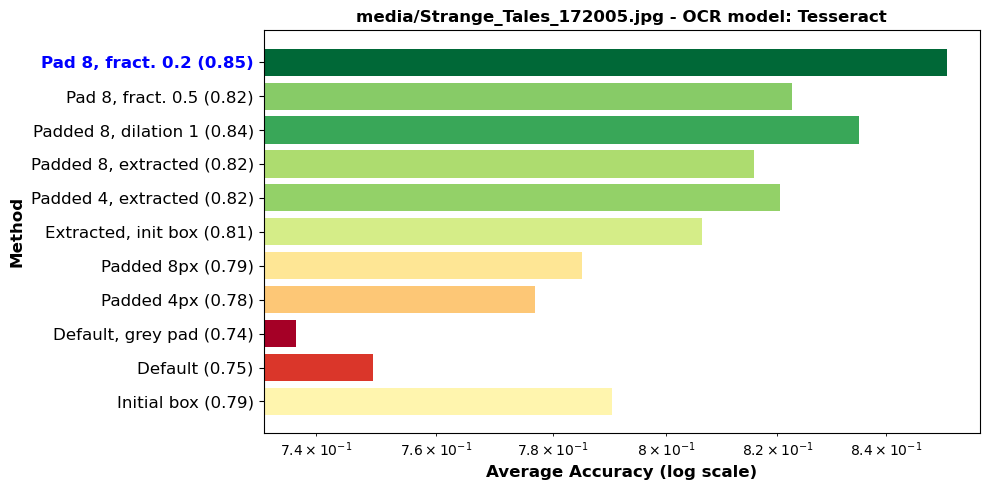

In [100]:
image_experiment.perform_methods(plot_acc=True)


In [101]:
image_experiment.display()

---------- Initial box ----------
ResultOCR#block 00: 0.90||Eneonered by great gnarled cypress jrfes, the ancient manor stands alone on the outski) 2 of mew ce eans, kept tidy by a white-haired old man known only as bambs, 3
ResultOCR#block 01: 0.93||The house and the old man are alike in many ways; tall, prolid, patient, contented always 0 wait until. their. master cones mome ~~
ResultOCR#block 02: 0.70||“and one in ee would appear.
ResultOCR#block 03: 0.62||Re bambli-~ we have a
ResultOCR#block 04: 0.70||Tonight, he comes noost slamming open the caken
ResultOCR#block 05: 0.82||Tell me naster. how may bambli serve 7
ResultOCR#block 06: 0.56||£7 » and perhaps some dry clothes... 7 /
ResultOCR#block 07: 0.81||The the old man's fades down the hall as... 7
ResultOCR#block 08: 0.85||How curious the 4 fate. whims of had t not chanced to stroll along the river yl tonight ==
ResultOCR#block 09: 0.80||Fas oulckly as t ca, master.
ResultOCR#block 10: 0.91||<the girl would - most slirely be dead by now.
ResultOCR#block 11: 0.47||Ath the girl. a second chance ge a ee yg adil
ResultOCR#block 12: 0.84||Ah girl--there's othing to scream ntt anymore .
ResultOCR#block 13: 0.93||You're among friends now. you're sale
ResultOCR#block 14: 1.00||Continued after next page

 ---------- Default ----------
ResultOCR#block 00: 0.85||Eneowered by great gnarled cypress jrfes, the ancient manor ! alone on the eit of mew rce: eans, kept tipy by a white-haired ao han known only as
ResultOCR#block 01: 0.96||The house and the old man are alike in many ways; tall, proud, patient, conten tel always to wait until their. master cones home ~~
ResultOCR#block 02: 0.74||And one in ee would appear.
ResultOCR#block 03: 0.41||Rir guest.
ResultOCR#block 04: 0.59||=~and tonight, he comes host sane oo
ResultOCR#block 05: 0.78||Tell me masts - how may bambli . serve 7 _
ResultOCR#block 06: 0.48||R warm, bambli-~ and perhaps
ResultOCR#block 07: 0.76||The the old mans fades down the hall s.00
ResultOCR#block 08: 0.92||How curious the a whims of fate . had t not chanced to stroll along the river tonight~~ >
ResultOCR#block 09: 0.50||Aulckly “master as t can,
ResultOCR#block 10: 0.94||<the girl would - most surely be dead by now.
ResultOCR#block 11: 0.50||Ath - the girl. a second chance ee oo tr tt
ResultOCR#block 12: 0.84||Oe girl--there's othing to scream nt anymore. 4
ResultOCR#block 13: 0.96||You're among friends now. youre safe!
ResultOCR#block 14: 1.00||Continued after next page

 ---------- Default, grey pad ----------
ResultOCR#block 00: 0.95||Enbowered by great gnarled cypress trees, the ancient manor stands alone on the outskirts of new orleans, kept tipy by a white-haired old man known only as
ResultOCR#block 01: 0.96||The house and the old man are alike in many ways; tall, prolid, patient, contented always to wait until their. * master cones home ~-
ResultOCR#block 02: 0.94||“and one in > need of some help, it would appear .
ResultOCR#block 03: 0.88||" bambl-- we have a guest.
ResultOCR#block 04: 0.72||~~and tonight, he comes urgently, slanming open
ResultOCR#block 05: 0.86||Tell me, master: how may bambli serve 7
ResultOCR#block 06: 0.90||Some blankets to keep her. warm, bambli-- and perhaps some dry \ clothes--7 /.
ResultOCR#block 07: 0.06||As.
ResultOCR#block 08: 0.91||How curious the d 7e . whims of fa; had i not chanced to stroll along the river tonight--
ResultOCR#block 09: 0.55||Ickl as t can
ResultOCR#block 10: 0.00||
ResultOCR#block 11: 0.85||Ghede has been generous. the death god has gen + the girl. a second chance te oe ato" pd ate
ResultOCR#block 12: 0.95||Easy, girl--there's | nothing to scream about anyaore.
ResultOCR#block 13: 0.97||You're among friends now. you're safe!
ResultOCR#block 14: 0.54||“continued a

 ---------- Padded 4px ----------
ResultOCR#block 00: 0.88||Enbonered by great gnarled cypress jrfes, the ancient manor stands alone on the eit of mew rce: eans, kept tipy by a white-haired ao lo man known only as
ResultOCR#block 01: 0.93||The 

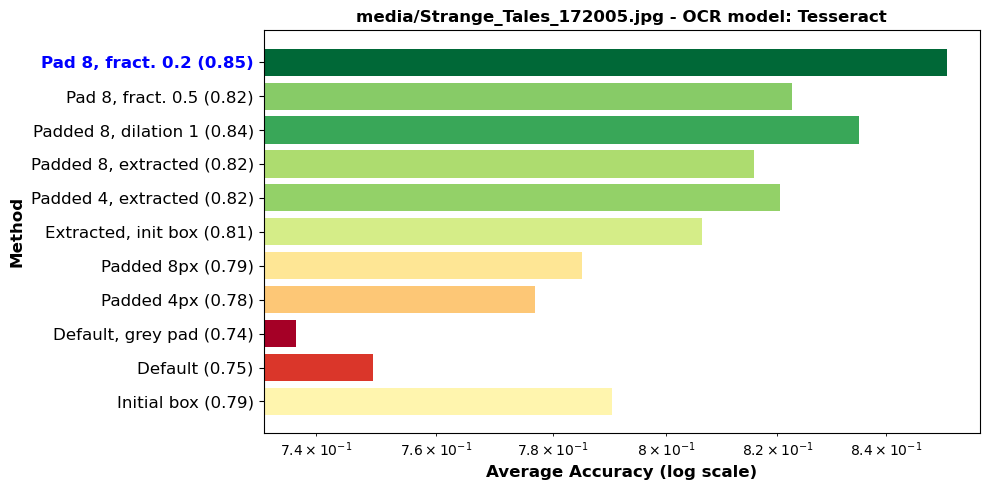

In [102]:
image_experiment.plot_accuracies()


In [103]:
RenderJSON(image_experiment.to_dict(), 400, 2)


best results

In [104]:
ll = image_experiment.best_results()
if ll:
    cprint([(m.value, f"{r.acc:.3f}", r.ocr) for m,r in ll])


[
    (
        'Default, grey pad',
        '0.953',
        'Enbowered by great gnarled cypress trees, the ancient manor stands alone on the outskirts of 
new orleans, kept tipy by a white-haired old man known only as'
    ),
    (
        'Padded 8px',
        '0.988',
        'The house and the old man are alike in many ways; tall, proud, patient, contented always to 
wait until their. master comes home'
    ),
    ('Padded 8, dilation 1', '0.968', 'And one in need of some help, it wolld appear .'),
    ('Default, grey pad', '0.880', '" bambl-- we have a guest.'),
    ('Padded 8, dilation 1', '0.794', '=and tonight, he comes most slamming open the front'),
    ('Default, grey pad', '0.857', 'Tell me, master: how may bambli serve 7'),
    (
        'Pad 8, fract. 0.5',
        '0.935',
        'Some blankets to keep her. warm, bambli-~ and perhaps. some dry clothes'
    ),
    ('Initial box', '0.811', "The the old man's fades down the hall as... 7"),
    (
        'Padded 8, extracted',
        '0.959',
        'How curious the whims of fate . had i not chanced to stroll along the river tonight-~'
    ),
    ('Extracted, init box', '0.846', 'Aulckly as t can, master,'),
    ('Extracted, init box', '1.000', '--the girl would most surely be dead by now.'),
    (
        'Padded 8, extracted',
        '0.935',
        'Ghede has been generous. the peath god has given the girl a second chance po'
    ),
    ('Default, grey pad', '0.953', "Easy, girl--there's | nothing to scream about anyaore."),
    ('Default, grey pad', '0.974', "You're among friends now. you're safe!"),
    ('Initial box', '1.000', 'Continued after next page')
]

Perfom experiments given a list of `CropMethod`s


In [105]:
# methods = [*CropMethod.__members__.values()]
methods = [CropMethod.INITIAL_BOX, CropMethod.DEFAULT]
image_experiment.perform_methods(methods)


Plot the perfomance of the experiments

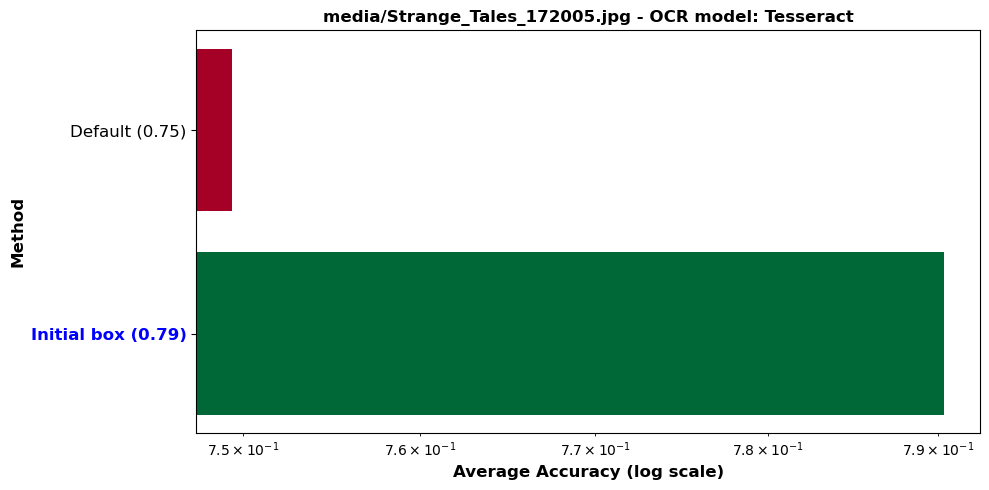

In [106]:
# image_experiment.plot_accuracies(exps, IMAGE_CONTEXT)
image_experiment.plot_accuracies(methods)


Save the results to a file


In [107]:
fp, json_results = image_experiment.to_json()
cprint(fp)
RenderJSON(json_results, 300, 2)


cleaner/Strange_Tales_172005/Strange_Tales_172005_Tesseract.json

Load the results from a file


In [108]:
saved_exp = ExperimentOCR.from_json(CONTEXT, fp)
saved_exp.display()


---------- Initial box ----------
ResultOCR#block 00: 0.90||Eneonered by great gnarled cypress jrfes, the ancient manor stands alone on the outski) 2 of mew ce eans, kept tidy by a white-haired old man known only as bambs, 3
ResultOCR#block 01: 0.93||The house and the old man are alike in many ways; tall, prolid, patient, contented always 0 wait until. their. master cones mome ~~
ResultOCR#block 02: 0.70||“and one in ee would appear.
ResultOCR#block 03: 0.62||Re bambli-~ we have a
ResultOCR#block 04: 0.70||Tonight, he comes noost slamming open the caken
ResultOCR#block 05: 0.82||Tell me naster. how may bambli serve 7
ResultOCR#block 06: 0.56||£7 » and perhaps some dry clothes... 7 /
ResultOCR#block 07: 0.81||The the old man's fades down the hall as... 7
ResultOCR#block 08: 0.85||How curious the 4 fate. whims of had t not chanced to stroll along the river yl tonight ==
ResultOCR#block 09: 0.80||Fas oulckly as t ca, master.
ResultOCR#block 10: 0.91||<the girl would - most slirely be dead by now.
ResultOCR#block 11: 0.47||Ath the girl. a second chance ge a ee yg adil
ResultOCR#block 12: 0.84||Ah girl--there's othing to scream ntt anymore .
ResultOCR#block 13: 0.93||You're among friends now. you're sale
ResultOCR#block 14: 1.00||Continued after next page

 ---------- Default ----------
ResultOCR#block 00: 0.85||Eneowered by great gnarled cypress jrfes, the ancient manor ! alone on the eit of mew rce: eans, kept tipy by a white-haired ao han known only as
ResultOCR#block 01: 0.96||The house and the old man are alike in many ways; tall, proud, patient, conten tel always to wait until their. master cones home ~~
ResultOCR#block 02: 0.74||And one in ee would appear.
ResultOCR#block 03: 0.41||Rir guest.
ResultOCR#block 04: 0.59||=~and tonight, he comes host sane oo
ResultOCR#block 05: 0.78||Tell me masts - how may bambli . serve 7 _
ResultOCR#block 06: 0.48||R warm, bambli-~ and perhaps
ResultOCR#block 07: 0.76||The the old mans fades down the hall s.00
ResultOCR#block 08: 0.92||How curious the a whims of fate . had t not chanced to stroll along the river tonight~~ >
ResultOCR#block 09: 0.50||Aulckly “master as t can,
ResultOCR#block 10: 0.94||<the girl would - most surely be dead by now.
ResultOCR#block 11: 0.50||Ath - the girl. a second chance ee oo tr tt
ResultOCR#block 12: 0.84||Oe girl--there's othing to scream nt anymore. 4
ResultOCR#block 13: 0.96||You're among friends now. youre safe!
ResultOCR#block 14: 1.00||Continued after next page

 ---------- Default, grey pad ----------
ResultOCR#block 00: 0.95||Enbowered by great gnarled cypress trees, the ancient manor stands alone on the outskirts of new orleans, kept tipy by a white-haired old man known only as
ResultOCR#block 01: 0.96||The house and the old man are alike in many ways; tall, prolid, patient, contented always to wait until their. * master cones home ~-
ResultOCR#block 02: 0.94||“and one in > need of some help, it would appear .
ResultOCR#block 03: 0.88||" bambl-- we have a guest.
ResultOCR#block 04: 0.72||~~and tonight, he comes urgently, slanming open
ResultOCR#block 05: 0.86||Tell me, master: how may bambli serve 7
ResultOCR#block 06: 0.90||Some blankets to keep her. warm, bambli-- and perhaps some dry \ clothes--7 /.
ResultOCR#block 07: 0.06||As.
ResultOCR#block 08: 0.91||How curious the d 7e . whims of fa; had i not chanced to stroll along the river tonight--
ResultOCR#block 09: 0.55||Ickl as t can
ResultOCR#block 10: 0.00||
ResultOCR#block 11: 0.85||Ghede has been generous. the death god has gen + the girl. a second chance te oe ato" pd ate
ResultOCR#block 12: 0.95||Easy, girl--there's | nothing to scream about anyaore.
ResultOCR#block 13: 0.97||You're among friends now. you're safe!
ResultOCR#block 14: 0.54||“continued a

 ---------- Padded 4px ----------
ResultOCR#block 00: 0.88||Enbonered by great gnarled cypress jrfes, the ancient manor stands alone on the eit of mew rce: eans, kept tipy by a white-haired ao lo man known only as
ResultOCR#block 01: 0.93||The 

Get experiment for image idx


In [109]:
saved_exp = ExperimentOCR.saved_experiment(CONTEXT, 'Tesseract', IMAGE_CONTEXT.image_idx)
# saved_exp = ExperimentOCR.saved_experiment(IMAGE_CONTEXT, 'Tesseract', 'Action_Comics_1960-01-00_(262).JPG')
if saved_exp:
    saved_exp.method_experiment(CropMethod.PAD_8_FRACT_0_2).display()


Box #,Image,Accuracy,OCR
1,,0.94,"Enbonered by great snarled cypress trees, the ancient manor stands alone on the outskirts of new orleans, kept tipy by a whi⎕te-haired old man known only as b8ambl ."
2,,0.97,"The house and the old man are alike in many ways; tall, proud, patient, contented always t° wait until their. master comes home ~~"
3,,0.77,And one in ⎕eet⎕⎕⎕ sv⎕e⎕⎕⎕⎕⎕⎕⎕⎕⎕ would appear.
4,,0.86,Bambl ~~ we have a guest.
5,,0.64,"=~and tonight, he comes ⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕slamming open urg⎕⎕⎕⎕en⎕⎕⎕⎕⎕tly,⎕⎕⎕⎕"
6,,0.82,Tell me⎕ master... how may bambli serve'7
7,,0.94,"Some blankets to keep her, warm, bambli-~ and perhaps. some dry clothes"
8,,0.75,The⎕⎕⎕⎕⎕⎕⎕⎕ the old man⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕⎕s fades down the hall ⎕sere
9,,0.96,How curious the whims of fate⎕. had i not chanced to stroll along the river tonight-~
10,,0.81,"A⎕⎕⎕ulckry as t can, master."


Perform experiments for selected boxes y methods

In [110]:
image_experiment(
    box_idxs=[0, 1, 2, 3],
    methods=[CropMethod.INITIAL_BOX, CropMethod.DEFAULT],
    rebuild=False,
    display=True,
    save=False,
    save_as_ground_truth=False
)


---------- Initial box ----------
ResultOCR#block 00: 0.90||Eneonered by great gnarled cypress jrfes, the ancient manor stands alone on the outski) 2 of mew ce eans, kept tidy by a white-haired old man known only as bambs, 3
ResultOCR#block 01: 0.93||The house and the old man are alike in many ways; tall, prolid, patient, contented always 0 wait until. their. master cones mome ~~
ResultOCR#block 02: 0.70||“and one in ee would appear.
ResultOCR#block 03: 0.62||Re bambli-~ we have a
ResultOCR#block 04: 0.70||Tonight, he comes noost slamming open the caken
ResultOCR#block 05: 0.82||Tell me naster. how may bambli serve 7
ResultOCR#block 06: 0.56||£7 » and perhaps some dry clothes... 7 /
ResultOCR#block 07: 0.81||The the old man's fades down the hall as... 7
ResultOCR#block 08: 0.85||How curious the 4 fate. whims of had t not chanced to stroll along the river yl tonight ==
ResultOCR#block 09: 0.80||Fas oulckly as t ca, master.
ResultOCR#block 10: 0.91||<the girl would - most slirely be dead by now.
ResultOCR#block 11: 0.47||Ath the girl. a second chance ge a ee yg adil
ResultOCR#block 12: 0.84||Ah girl--there's othing to scream ntt anymore .
ResultOCR#block 13: 0.93||You're among friends now. you're sale
ResultOCR#block 14: 1.00||Continued after next page

 ---------- Default ----------
ResultOCR#block 00: 0.85||Eneowered by great gnarled cypress jrfes, the ancient manor ! alone on the eit of mew rce: eans, kept tipy by a white-haired ao han known only as
ResultOCR#block 01: 0.96||The house and the old man are alike in many ways; tall, proud, patient, conten tel always to wait until their. master cones home ~~
ResultOCR#block 02: 0.74||And one in ee would appear.
ResultOCR#block 03: 0.41||Rir guest.
ResultOCR#block 04: 0.59||=~and tonight, he comes host sane oo
ResultOCR#block 05: 0.78||Tell me masts - how may bambli . serve 7 _
ResultOCR#block 06: 0.48||R warm, bambli-~ and perhaps
ResultOCR#block 07: 0.76||The the old mans fades down the hall s.00
ResultOCR#block 08: 0.92||How curious the a whims of fate . had t not chanced to stroll along the river tonight~~ >
ResultOCR#block 09: 0.50||Aulckly “master as t can,
ResultOCR#block 10: 0.94||<the girl would - most surely be dead by now.
ResultOCR#block 11: 0.50||Ath - the girl. a second chance ee oo tr tt
ResultOCR#block 12: 0.84||Oe girl--there's othing to scream nt anymore. 4
ResultOCR#block 13: 0.96||You're among friends now. youre safe!
ResultOCR#block 14: 1.00||Continued after next page

 ---------- Default, grey pad ----------
ResultOCR#block 00: 0.95||Enbowered by great gnarled cypress trees, the ancient manor stands alone on the outskirts of new orleans, kept tipy by a white-haired old man known only as
ResultOCR#block 01: 0.96||The house and the old man are alike in many ways; tall, prolid, patient, contented always to wait until their. * master cones home ~-
ResultOCR#block 02: 0.94||“and one in > need of some help, it would appear .
ResultOCR#block 03: 0.88||" bambl-- we have a guest.
ResultOCR#block 04: 0.72||~~and tonight, he comes urgently, slanming open
ResultOCR#block 05: 0.86||Tell me, master: how may bambli serve 7
ResultOCR#block 06: 0.90||Some blankets to keep her. warm, bambli-- and perhaps some dry \ clothes--7 /.
ResultOCR#block 07: 0.06||As.
ResultOCR#block 08: 0.91||How curious the d 7e . whims of fa; had i not chanced to stroll along the river tonight--
ResultOCR#block 09: 0.55||Ickl as t can
ResultOCR#block 10: 0.00||
ResultOCR#block 11: 0.85||Ghede has been generous. the death god has gen + the girl. a second chance te oe ato" pd ate
ResultOCR#block 12: 0.95||Easy, girl--there's | nothing to scream about anyaore.
ResultOCR#block 13: 0.97||You're among friends now. you're safe!
ResultOCR#block 14: 0.54||“continued a

 ---------- Padded 4px ----------
ResultOCR#block 00: 0.88||Enbonered by great gnarled cypress jrfes, the ancient manor stands alone on the eit of mew rce: eans, kept tipy by a white-haired ao lo man known only as
ResultOCR#block 01: 0.93||The 

## On any image

In [111]:
test_fail(lambda: ExperimentOCR.from_image(CONTEXT, 'Tesseract', 37), 'out of range')


In [112]:
ImageContextVisor(CONTEXT, 'Action_Comics_1960-01-00_(262).JPG')


Output(layout=Layout(height='0px'))

Output()

In [113]:
image_action_experiment: ExperimentOCR = cast(ExperimentOCR, ExperimentOCR.from_image(
                            CONTEXT, 'Tesseract', 'Action_Comics_1960-01-00_(262).JPG'))
image_action_experiment.display()


---------- Initial box ----------
ResultOCR#block 00: 0.90||Suddenly.
ResultOCR#block 01: 0.81||>gasp!z everything's w- whirling around me!t can't stand sr rea
ResultOCR#block 02: 0.81||Clark!i'm falling' “help! help! —
ResultOCR#block 03: 0.67||I-i'm bs "passing ohhh
ResultOCR#block 04: 0.92||Action comics
ResultOCR#block 05: 1.00||Then, seconds later...
ResultOCR#block 06: 0.89||Great caesars ghost! { this /s black magic! we've been transportel to the weirdest world, tit ever saw!
ResultOCR#block 07: 0.91||...|t certainly isn't our earth, perry. look at the size of those bees.
ResultOCR#block 08: 0.88||Watch out, clark!
ResultOCR#block 09: 0.73||Owwww.
ResultOCR#block 10: 0.85||Yet the bee's stinger went ws. right through my uniform and penetrated my skin! that means. the fabric of pe ay costume has become dj} satie fued 1,
ResultOCR#block 11: 0.87||Hurry. let's beat it before we get stung, foo = aii
ResultOCR#block 12: 0.86||Ggreat guns!...2g, .pa/n i feel n pain! as superman, i should be > invulnerable! 1 have unbreakabl ‘skin! under my clark kent clothes, im wearing an woestructisle superman uniform ! =
ResultOCR#block 13: 1.00||Abruptly...
ResultOCR#block 14: 0.77||Great caesar's ghost. he's spinning a web of g/ant, sr strands --
ResultOCR#block 15: 0.89||I-i feel the heat of the sun...the pain of the bee-sting ... the heavy weight of my pack! every human discomfort... good grief! i've lost all my super-powers! i've become an ordinary mortal in this world. /
ResultOCR#block 16: 0.84||Enormous spider- like creature is going berserk, as if the sight of us excited him (into mad spinning get back! that 2

 ---------- Default ----------
ResultOCR#block 00: 1.00||Suddenly...
ResultOCR#block 01: 0.80||Gasp! everything's w- whi rns atound me!i can't stand we a
ResultOCR#block 02: 0.87||Clark!i'm falling! help! help
ResultOCR#block 03: 0.45||I-i'm se ou
ResultOCR#block 04: 0.92||Action comics
ResultOCR#block 05: 0.95||Then, seconds later.
ResultOCR#block 06: 0.92||Great caesar's ghost! this /s black magic! we've been transported, to the weirdest world, i ever saw!
ResultOCR#block 07: 0.93||...|t certainly isn't our earth, perry look at the size of those bees!
ResultOCR#block 08: 0.88||Watch out, clark)
ResultOCR#block 09: 0.67||Owwww.,
ResultOCR#block 10: 0.97||Yet the bee's stinger went = right through my uniform ando penetrated my skin! that mean the fabric of my superman costume has become ordinary, cloth! £
ResultOCR#block 11: 0.89||Hurry. let's beat it before we get stung, tod yi
ResultOCR#block 12: 0.88||Ggreat guns!...2gasp/z...pain i feel n fan! as superman, i should be invulnerable! 1 have unbreakable skin! under my clark kent clothes, i'm wearing an /noestruct/ele superman uniform !
ResultOCR#block 13: 1.00||Abruptly...
ResultOCR#block 14: 0.76||Great caesars ° ghost! he's spinning & web of g/a, silk strands
ResultOCR#block 15: 0.89||I-i feel the heat of the sum...the pain of the bee-sting... the heavy weight of my { pack! every human discomfort... good grief! i've lost all my super -powersx ve become an ordinary mortal in this world! j
ResultOCR#block 16: 0.70||Like creature is going berserk, as if the sight of us excited him into mad spinning, get back! that \ enormous spider-

 ---------- Default, grey pad ----------
ResultOCR#block 00: 0.78||Sudden.
ResultOCR#block 01: 0.82||5gasp!z everything's | w- whirling around] me!t can't stand ue a
ResultOCR#block 02: 0.57||Ark!i'm falling
ResultOCR#block 03: 0.85||I-t'm eq "passing out... ohhh.
ResultOCR#block 04: 0.92||Action comics
ResultOCR#block 05: 0.00||
ResultOCR#block 06: 0.88||‘great caesar's ghost! || this /§ black magic! we've been transportel to the weirdest world, i ever saw.
ResultOCR#block 07: 0.87||"...it certainly isn't our | earth, perry look at the| \s|ze of those bees.
ResultOCR#block 08: 0.88||Watch out, clark!
ResultOCR#block 09: 0.73||Owwww.
ResultOCR#block 10: 0.90||Yet the bee's stinger went ~ right through my uniform and penetrated my skin! that mea

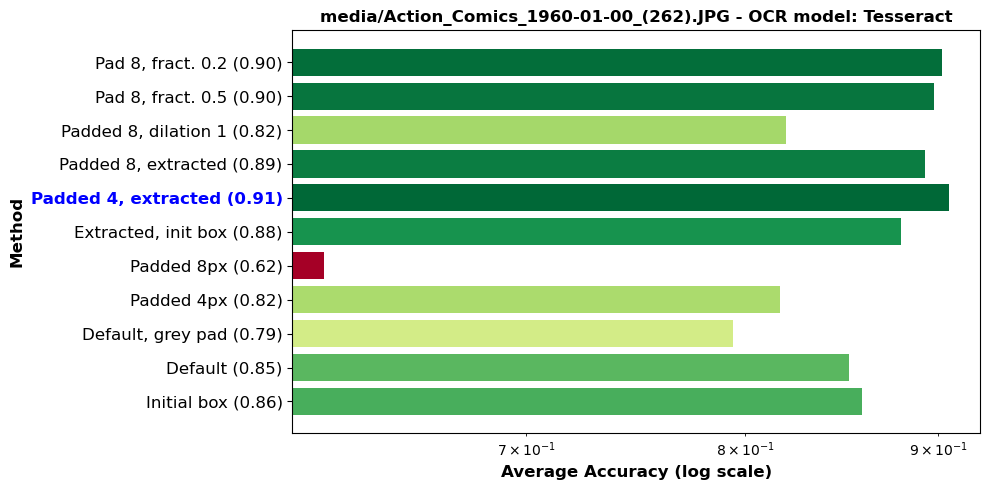

In [114]:
image_action_experiment.plot_accuracies()


In [115]:
image_action_experiment.result(14, CropMethod.PADDED_4)


,"Great caesars ghost. he's spinning a web of g/ant, | silk strands as tough as steel!0.91"


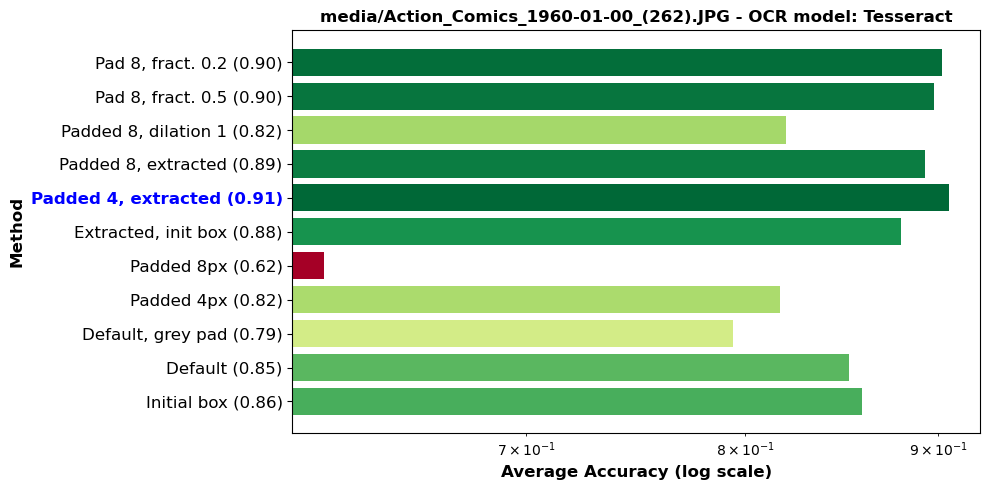

In [116]:
image_action_experiment.perform_methods(plot_acc=True)


# Everything Everywhere All at Once


In [117]:
CONTEXT.reset()


## ExperimentsVisor

In [121]:
#| export

class ExperimentsVisor(ContextVisor):
    ctx: OCRExperimentContext

    def update_output(self, 
            model: OCRModel | None = None,
            image_idx: ImgIdT | None = None,
            display_option: DisplayOptions | None = None, 
            **kwargs):
        model_selector, image_selector, content_selector, result_visor = self._comps()
        if model is not None:
            exp_ctx = result_visor.ctx
            exp_ctx.ocr_model = list(model_selector.models.keys())[model.value]
            result_visor.ctx = exp_ctx
        if image_idx is not None:
            img_ctx = ImageContext(self.ctx, image_idx)
            result_visor.ctx.ctx = img_ctx
            display_option = content_selector.values['display_option']
        if display_option is not None and display_option != DisplayOptions.RESULTS:
            result_visor.hide()
            if display_option == DisplayOptions.BEST_RESULTS:
                result_visor.best_results()
            elif display_option == DisplayOptions.DATAFRAME:
                result_visor.pd_to_html()
            else:
                content_selector.display_content(image_selector.image_ctx, display_option)
        else:
            result_visor.show()
            result_visor.update_output(**kwargs)

    def _comps(self):
        cc = self.comps
        msel: ModelSelector = cc['model_selector']  # type: ignore
        isel: ImageSelector = cc['image_selector']  # type: ignore
        cs: ContentSelector = cc['content_selector']  # type: ignore
        rv: ResultVisor = cc['result_visor']  # type: ignore
        return msel, isel, cs, rv

    def setup_ui(self):
        ctls = self.controls.values()
        msw, isw, csw, rvw = [_.w for _ in self._comps()]
        return W.VBox([W.HBox([msw, isw, csw, *ctls]), rvw,])

    def __init__(self, 
            ctx: OCRExperimentContext,
            image_idx: ImgIdT | str | Path = 0,
            ocr_model: OCRModel = OCRModel.TESSERACT,
            display_option: DisplayOptions = DisplayOptions.RESULTS,
            all_boxes: bool = False,
            box_idx: int = 0,
            all_methods: bool = False,
            method: CropMethod=CropMethod.INITIAL_BOX,
            ocr_models: dict[str, OCRModel] = {'Tesseract': OCRModel.TESSERACT},
            out: W.Output | None = None,
        ):
        if not isinstance(ctx, OCRExperimentContext):
            raise ValueError("ctx must be an OCRExperimentContext")
        exp = ExperimentOCR.from_image(ctx, 'Tesseract', image_idx)
        if not exp:
            raise ValueError(f"Image {image_idx} not found in experiment context")
        
        out = out or self.out
        model_selector = ModelSelector(ctx, ocr_model=ocr_model, 
            ocr_models=ocr_models, out=out)
        image_selector = ImageSelector(ctx, image_idx=image_idx, out=out)
        content_selector = ContentSelector(ctx, display_option=display_option, out=out)
        result_visor = ResultVisor(exp, out=out,
            all_boxes=all_boxes, box_idx=box_idx, all_methods=all_methods, method=method)

        super().__init__(ctx, {}, out=out, 
                    ctxs={'model_selector': model_selector, 'image_selector': image_selector, 'content_selector': content_selector, 
                        'result_visor': result_visor}
                    )


# Visualize all

In [122]:
# tesseract_experiment = ExperimentsVisor(CONTEXT)
tesseract_experiment = ExperimentsVisor(CONTEXT, BASE_IMAGE_IDX)

test_eq(tesseract_experiment.all_values, {
    'image_selector': {'image_idx': 20},
    'content_selector': {'display_option': DisplayOptions.RESULTS},
    'result_visor': {
        'all_boxes': False,
        'box_idx': 0,
        'all_methods': False,
        'method': CropMethod.INITIAL_BOX,
    },
    'model_selector': {'model': OCRModel.TESSERACT},
    'self': {}
})

tesseract_experiment


Output()

In [121]:
tesseract_experiment.update(display_option=DisplayOptions.BOXES)


# Colophon
----


In [122]:
import fastcore.all as FC
from nbdev.export import nb_export


In [124]:
if FC.IN_NOTEBOOK:
    nb_export('experiments.ipynb', '.')
